In [1]:
import os
import pandas as pd
from google.oauth2.service_account import Credentials
from googleapiclient.discovery import build
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from google.oauth2.service_account import Credentials
from googleapiclient.discovery import build

### TeleSales Data

In [2]:
SERVICE_ACCOUNT_FILE = "credentials.json"
SCOPES = ['https://www.googleapis.com/auth/spreadsheets']
SHEET_ID = '1tQM2OplJqPHodWNyXDsQpyOJ7gHhC51Inar6njKH9Qk'
RESEARCHER_SHEETS = ["Vincy Sheet", "Harris Sheet", "Shai Sheet",
    "Dominic Sheet"]

credentials = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
service = build('sheets', 'v4', credentials=credentials)
sheet_api = service.spreadsheets()

def fetch_sheet(sheet_name):
    range_a1 = f"'{sheet_name}'!A:ZZ"
    result = sheet_api.values().get(spreadsheetId=SHEET_ID, range=range_a1).execute()
    values = result.get('values', [])
    if not values:
        print(f"❌ No data found in {sheet_name}")
        return pd.DataFrame()
    
    header = values[0]
    data_rows = values[1:]
    max_len = max([len(header)] + [len(r) for r in data_rows])
    if len(header) < max_len:
        header += [f'col_{i+1}' for i in range(len(header), max_len)]
    
    # Fix the first column name if it's empty
    if header and (header[0] == '' or header[0].strip() == ''):
        header[0] = 'ePOS Code'
    
    normalized_rows = [r + ['']*(max_len-len(r)) for r in data_rows]
    df = pd.DataFrame(normalized_rows, columns=header)
    
    # Filter out rows where ePOS Code is empty or None
    if 'ePOS Code' in df.columns:
        df = df[df['ePOS Code'].astype(str).str.strip() != '']
    
    return df

researcher_data = {}
all_researcher_dfs = []  # List to collect all dataframes

for s in RESEARCHER_SHEETS:
    df = fetch_sheet(s)
    researcher_data[s] = df
    all_researcher_dfs.append(df)  # Append each df to the list
    print(f"Researcher: {s} | Rows: {df.shape[0]} | Columns: {df.shape[1]}")

# Get all unique column names from all dataframes
all_columns = []
for df in all_researcher_dfs:
    all_columns.extend(df.columns.tolist())
all_columns = list(dict.fromkeys(all_columns))  # Remove duplicates while preserving order

print(f"\nTotal unique columns across all sheets: {len(all_columns)}")

# Align all dataframes to have the same columns in the same order
aligned_dfs = []
for df in all_researcher_dfs:
    # Reindex each dataframe to have all columns, filling missing ones with empty strings
    aligned_df = df.reindex(columns=all_columns, fill_value='')
    aligned_dfs.append(aligned_df)

# Combine all researcher dataframes into a single dataframe
combined_researcher_df = pd.concat(aligned_dfs, ignore_index=True)

# Filter out rows where ePOS Code is empty in the combined dataframe
if 'ePOS Code' in combined_researcher_df.columns:
    combined_researcher_df = combined_researcher_df[combined_researcher_df['ePOS Code'].astype(str).str.strip() != '']

print(f"Combined DataFrame | Total Rows: {combined_researcher_df.shape[0]} | Total Columns: {combined_researcher_df.shape[1]}")

# Display sample data
combined_researcher_df.head(5)

Researcher: Vincy Sheet | Rows: 1728 | Columns: 40
Researcher: Harris Sheet | Rows: 1424 | Columns: 40
Researcher: Shai Sheet | Rows: 4035 | Columns: 40
Researcher: Dominic Sheet | Rows: 2983 | Columns: 40

Total unique columns across all sheets: 40
Combined DataFrame | Total Rows: 10170 | Total Columns: 40


,ePOS Code,Company Code,Date MR Lead Created,Acra Registered Name,Associated Company,Name of the Market Researcher,Source,Sub Industry,Business Type,Ownership Type,...,Call Outcome,Demo Outcome,Sales Won,Date of the 1st Follow up call,Date of the 2nd follow up call,Information on the 3rd follow up onwards,Notes/Challenges,Material Sent?,Call Connected Date,Meeting Fixed Date
0,EPOS000024,COM000009,22/04/2025,JEFFREY HAIR SALON,Jeffrey Hair Saloon,Shafiqah,Market Research,Hair Salons & Barbershops,SME,Local Company,...,Connected,Not Fixed,,30/10/2025,28/11/2025,,"22/10 - call , but background is chinese fm s...",FALSE,,
1,EPOS000026,COM000011,22/04/2025,JC NAIL SPA,I.A Nail Spa Lashes,Shafiqah,Market Research,"Beauty & Wellness (Spas, Massage, Skincare)",SME,Sole Proprietorship/ Partnership,...,Not Interested,,,29/10/2025,,,"29/10 ， call to ms , once said psg grant , nop...",FALSE,,
2,EPOS599944,COM599953,29/04/2025,ANOTHER ONE FASHION BOUTIQUE,ANOTHER ONE,Kalaivani,Market Research,Fashion & Apparel,SME,Local Company,...,Not Interested,,,,,,"22/10 > call 6255 5830 , ms keep said x intere...",FALSE,,
3,EPOS450695,COM450707,21/05/2025,AJI STAR,AJI STAR,Kai Xin,Market Research,Convenience Stores,SME,Sole Proprietorship/ Partnership,...,Business Shut Down,,,,,,22/10 > call mr this business alreday close do...,FALSE,,
4,EPOS450641,COM450663,23/05/2025,LIT HENG SENG MINIMART,NEWCON - LIT HENG SENG MINIMART,Kai Xin,Market Research,Convenience Stores,Franchise,Sole Proprietorship/ Partnership,...,Connected,Not Fixed,,03/11/2025,,,"22/10 > call to 6444 2776 , ms ask to call 902...",FALSE,,


### Pulling from Master DB 

In [3]:
# Google Sheet ID
sheet_id = '1ipwIl7fciIlddvOUqGLpNlVQufw7Xd26Qa-YuJcx-xE'

SCOPES = ['https://www.googleapis.com/auth/spreadsheets']

# Prefer env var GOOGLE_APPLICATION_CREDENTIALS, else fallback
SERVICE_ACCOUNT_FILE = os.getenv("GOOGLE_APPLICATION_CREDENTIALS", "credentials.json")
if not os.path.exists(SERVICE_ACCOUNT_FILE):
    raise FileNotFoundError(
        f"Service account file not found at '{SERVICE_ACCOUNT_FILE}'. "
        "Set GOOGLE_APPLICATION_CREDENTIALS to the full path, or place credentials.json next to this notebook."
    )

credentials = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)

# Build service with increased timeout
import socket
socket.setdefaulttimeout(300)  # Set timeout to 5 minutes

service = build('sheets', 'v4', credentials=credentials)
sheet = service.spreadsheets()

# Pull entire sheet data (A:ZZ) with retry logic
range_a1 = "'MASTER DATABASE 2025 Template'!A:BJ"

max_retries = 3
retry_count = 0
values = None

while retry_count < max_retries:
    try:
        print(f"Fetching data from Google Sheets (attempt {retry_count + 1}/{max_retries})...")
        result = sheet.values().get(
            spreadsheetId=sheet_id,
            range=range_a1
        ).execute()
        values = result.get('values', [])
        print("✅ Data fetched successfully!")
        break
    except (socket.timeout, TimeoutError) as e:
        retry_count += 1
        if retry_count < max_retries:
            wait_time = 2 * retry_count  # Exponential backoff: 2s, 4s, 6s
            print(f"⚠️ Timeout occurred: {type(e).__name__}. Retrying in {wait_time}s... ({retry_count}/{max_retries})")
            import time
            time.sleep(wait_time)
        else:
            print("❌ Failed after maximum retries. Try reducing the range or check your connection.")
            raise
    except Exception as e:
        # Check if it's a transient network error worth retrying
        error_str = str(e).lower()
        if any(keyword in error_str for keyword in ['timeout', 'timed out', 'connection', 'network']):
            retry_count += 1
            if retry_count < max_retries:
                wait_time = 2 * retry_count
                print(f"⚠️ Network error: {e}. Retrying in {wait_time}s... ({retry_count}/{max_retries})")
                import time
                time.sleep(wait_time)
            else:
                print("❌ Failed after maximum retries due to network issues.")
                raise
        else:
            print(f"❌ Non-retryable error: {e}")
            raise

if values:
    header = values[0]
    data_rows = values[1:]

    max_len = max([len(header)] + [len(r) for r in data_rows]) if data_rows else len(header)
    if len(header) < max_len:
        header = header + [f'col_{i+1}' for i in range(len(header), max_len)]

    normalized_rows = [row + [''] * (max_len - len(row)) for row in data_rows]
    Master_DB_df = pd.DataFrame(normalized_rows, columns=header)
    print(f"Successfully loaded {len(Master_DB_df)} rows and {len(Master_DB_df.columns)} columns")
else:
    Master_DB_df = pd.DataFrame()
    print("No data found in the sheet")

# ---- NO MORE FILTERING COLUMNS ----
# Master_DB_df now keeps ALL COLUMNS from Google Sheets

Fetching data from Google Sheets (attempt 1/3)...
✅ Data fetched successfully!
Successfully loaded 13968 rows and 62 columns


### Merge MasterDB with TeleSales

In [4]:
print(Master_DB_df.shape)
print(combined_researcher_df.shape)

(13968, 62)
(10170, 40)


In [5]:
teleSales_df = combined_researcher_df.copy()
teleSales_df = teleSales_df[["ePOS Code", "Call Outcome", "Meeting Fixed Date", "Date of the 1st Call",  "Tele Sales Incharge"]]
teleSales_df.head(10)

,ePOS Code,Call Outcome,Meeting Fixed Date,Date of the 1st Call,Tele Sales Incharge
0,EPOS000024,Connected,,22/10/2025,Vincy
1,EPOS000026,Not Interested,,22/10/2025,Vincy
2,EPOS599944,Not Interested,,22/10/2025,Vincy
3,EPOS450695,Business Shut Down,,22/10/2025,Vincy
4,EPOS450641,Connected,,22/10/2025,Vincy
5,EPOS450643,Not Interested,,22/10/2025,Vincy
6,EPOS450648,Connected,,22/10/2025,Vincy
7,EPOS450607,Not Interested,,23/10/2025,Vincy
8,EPOS450608,Not Interested,,22/10/2025,Vincy
9,EPOS450611,Not Interested,,22/10/2025,Vincy


In [6]:
# Perform left outer join to merge Call Outcome and Meeting Fixed Date from teleSales_df into Master_DB_df
# This will keep all rows from Master_DB_df and add the matching columns from teleSales_df
Master_DB_df = Master_DB_df.merge(
    teleSales_df[["ePOS Code", "Call Outcome", "Date of the 1st Call", "Meeting Fixed Date", "Tele Sales Incharge"]],
    on='ePOS Code',
    how='left',
    suffixes=('', '_teleSales')
)


print(f"Master_DB_df shape after merge: {Master_DB_df.shape}")
print(f"\nSample of merged data:")
Master_DB_df[['ePOS Code', 'Call Outcome', 'Meeting Fixed Date', 'Date of the 1st Call', 'Tele Sales Incharge']].head(10)

Master_DB_df shape after merge: (13968, 66)

Sample of merged data:


,ePOS Code,Call Outcome,Meeting Fixed Date,Date of the 1st Call,Tele Sales Incharge
0,EPOS000001,Hang Up,,22/05/2025,Shai
1,EPOS000002,No Answer,,22/05/2025,Shai
2,EPOS000003,NaN,NaN,NaN,NaN
3,EPOS000004,NaN,NaN,NaN,NaN
4,EPOS000005,Number not in Use/Not Existing Number,,22/05/2025,Shai
5,EPOS000006,NaN,NaN,NaN,NaN
6,EPOS000007,NaN,NaN,NaN,NaN
7,EPOS000008,NaN,NaN,NaN,NaN
8,EPOS000009,NaN,NaN,NaN,NaN
9,EPOS000010,NaN,NaN,NaN,NaN


In [7]:
print(list(Master_DB_df.columns))


['ePOS Code', 'Company Code', 'Date', 'ACRA REGISTERED NAME', 'Brand/Deal Name/Business Name', 'Sub Domain Link (If Lead is already available in Backend) Fill only when EPOS client', 'Tele Sales or MR (For KPI - Internal)', 'Name of the Market Researcher', 'Original Source (Marketing)', 'Marketing Source (Do not fill anything if the leads are from Hubspot, EPOS clients)', 'Company Registration date / Date Established', 'Company Registration Number (UEN)', 'Primary SSIC Code', 'Secondary SSIC Code', 'Hubspot ID (Company)', 'Hubspot ID(Deal)', 'Hubspot ID(Contact)', 'Website URL', 'Business Type', 'Facebook Page', 'Instagram URL', 'Linkedin URL', 'Tik Tok URL', 'Ownership Type', 'Parent Industry Type', 'Industry Type', 'Sub Industry', 'Business model', 'Presence of Multiple Outlets', 'Number of Outlets (Write in #)', 'Region', 'Planning Area', 'Business Location Type', 'Registered Address (Block & Street)', 'Registered Address (Unit #)', 'Registered Address (Postal code)', 'Operational A

In [8]:
Master_DB_df.to_csv("masterDB.csv")

### Analyze Web Scrapping

=== Vincy's Web Scrapping Lead Analysis ===
Total leads for Vincy with Web Scrapping: 167

--- Call Status ---
Calls Made: 26 (15.6%)
Calls Not Made: 141 (84.4%)

--- Of 26 Calls Made ---
Connected: 1 (3.8%)
Other Outcomes: 15 (57.7%)

Other Outcomes Breakdown:
  No Answer: 12
  Not Interested: 2
  Wrong Number led to Wrong Business: 1


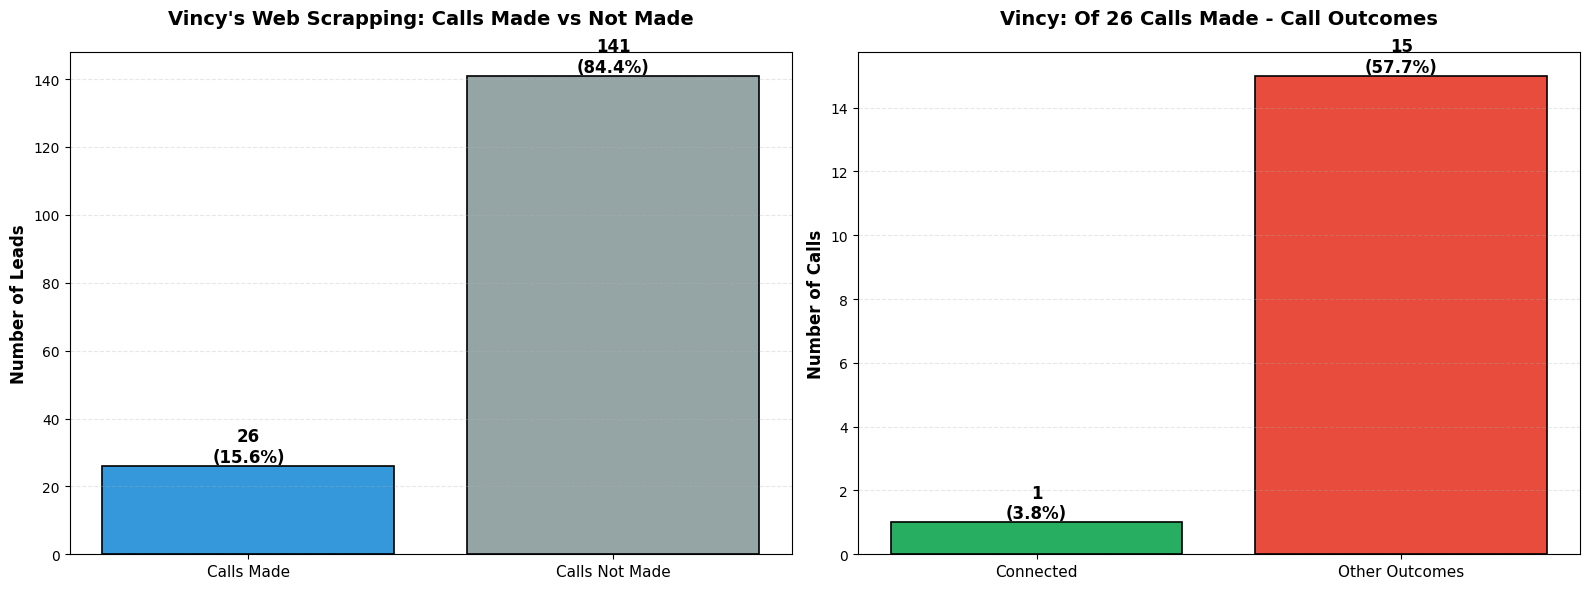

In [9]:
# Analyze Web Scrapping leads for Vincy - Calls Made and Connection Rate (OPTIMIZED)
import matplotlib.pyplot as plt
import numpy as np

# Filter criteria
tele_sales_col = 'Tele Sales Incharge'
marketing_col = 'Marketing Source (Do not fill anything if the leads are from Hubspot, EPOS clients)'
first_call_col = 'Date of the 1st Call'

# Step 1: Filter Master_DB_df for Vincy + Web Scrapping
vincy_web_scrapping = Master_DB_df[
    (Master_DB_df[tele_sales_col] == 'Vincy') &
    (Master_DB_df[marketing_col] == 'Web Scrapping')
].copy()

print(f"=== Vincy's Web Scrapping Lead Analysis ===")
print(f"Total leads for Vincy with Web Scrapping: {len(vincy_web_scrapping)}")

if len(vincy_web_scrapping) > 0:
    total_leads = len(vincy_web_scrapping)

    # Step 2: Separate calls made vs not made based on 'Date of the 1st Call'
    # Handle potential duplicate columns by getting the first occurrence
    first_call_data = vincy_web_scrapping[first_call_col]
    if isinstance(first_call_data, pd.DataFrame):
        first_call_data = first_call_data.iloc[:, 0]
    
    calls_made = vincy_web_scrapping[
        (first_call_data.notna()) &
        (first_call_data.astype(str).str.strip() != '')
    ].copy()

    calls_not_made = vincy_web_scrapping[
        (first_call_data.isna()) |
        (first_call_data.astype(str).str.strip() == '')
    ].copy()

    calls_made_count = len(calls_made)
    calls_not_made_count = len(calls_not_made)

    calls_made_pct = (calls_made_count / total_leads * 100) if total_leads > 0 else 0
    calls_not_made_pct = (calls_not_made_count / total_leads * 100) if total_leads > 0 else 0

    # Step 3: For calls made, analyze Call Outcome
    # Handle potential duplicate columns for Call Outcome
    call_outcome_data = calls_made['Call Outcome']
    if isinstance(call_outcome_data, pd.DataFrame):
        call_outcome_data = call_outcome_data.iloc[:, 0]
    
    # Filter out rows with empty/null Call Outcome
    calls_with_outcome = calls_made[
        (call_outcome_data.notna()) &
        (call_outcome_data.astype(str).str.strip() != '')
    ].copy()

    # Count Connected vs Other outcomes
    outcome_for_counting = calls_with_outcome['Call Outcome']
    if isinstance(outcome_for_counting, pd.DataFrame):
        outcome_for_counting = outcome_for_counting.iloc[:, 0]
    
    connected_count = len(calls_with_outcome[outcome_for_counting == 'Connected'])
    other_outcomes_count = len(calls_with_outcome[outcome_for_counting != 'Connected'])

    connected_pct = (connected_count / calls_made_count * 100) if calls_made_count > 0 else 0
    other_outcomes_pct = (other_outcomes_count / calls_made_count * 100) if calls_made_count > 0 else 0

    # Print summary
    print(f"\n--- Call Status ---")
    print(f"Calls Made: {calls_made_count} ({calls_made_pct:.1f}%)")
    print(f"Calls Not Made: {calls_not_made_count} ({calls_not_made_pct:.1f}%)")

    print(f"\n--- Of {calls_made_count} Calls Made ---")
    print(f"Connected: {connected_count} ({connected_pct:.1f}%)")
    print(f"Other Outcomes: {other_outcomes_count} ({other_outcomes_pct:.1f}%)")

    # Breakdown of other outcomes
    if other_outcomes_count > 0:
        other_outcome_series = calls_with_outcome['Call Outcome']
        if isinstance(other_outcome_series, pd.DataFrame):
            other_outcome_series = other_outcome_series.iloc[:, 0]
        
        other_outcome_breakdown = other_outcome_series[other_outcome_series != 'Connected'].value_counts()
        print(f"\nOther Outcomes Breakdown:")
        for outcome, count in other_outcome_breakdown.items():
            print(f"  {outcome}: {count}")

    # Create visualizations - Two column charts side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Chart 1: Calls Made vs Not Made
    categories1 = ['Calls Made', 'Calls Not Made']
    values1 = [calls_made_count, calls_not_made_count]
    colors1 = ['#3498DB', '#95A5A6']
    bars1 = ax1.bar(categories1, values1, color=colors1, edgecolor='black', linewidth=1.2)

    for bar, val in zip(bars1, values1):
        height = bar.get_height()
        pct = (val / total_leads * 100) if total_leads > 0 else 0
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}\n({pct:.1f}%)',
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

    ax1.set_ylabel('Number of Leads', fontsize=12, fontweight='bold')
    ax1.set_title("Vincy's Web Scrapping: Calls Made vs Not Made", fontsize=14, fontweight='bold', pad=20)
    ax1.tick_params(axis='x', labelsize=11)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')

    # Chart 2: Connected vs Other Outcomes (of calls made)
    categories2 = ['Connected', 'Other Outcomes']
    values2 = [connected_count, other_outcomes_count]
    colors2 = ['#27AE60', '#E74C3C']
    bars2 = ax2.bar(categories2, values2, color=colors2, edgecolor='black', linewidth=1.2)

    for bar, val in zip(bars2, values2):
        height = bar.get_height()
        pct = (val / calls_made_count * 100) if calls_made_count > 0 else 0
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}\n({pct:.1f}%)',
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

    ax2.set_ylabel('Number of Calls', fontsize=12, fontweight='bold')
    ax2.set_title(f"Vincy: Of {calls_made_count} Calls Made - Call Outcomes", fontsize=14, fontweight='bold', pad=20)
    ax2.tick_params(axis='x', labelsize=11)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.show()

else:
    print("No Web Scrapping leads found for Vincy.")

=== Dominic's Web Scrapping Lead Analysis ===
Total leads for Dominic with Web Scrapping: 97

--- Call Status ---
Calls Made: 13 (13.4%)
Calls Not Made: 84 (86.6%)

--- Of 13 Calls Made ---
Connected: 2 (15.4%)
Other Outcomes: 11 (84.6%)

Other Outcomes Breakdown:
  Number not in Use/Not Existing Number: 6
  No Answer: 3
  Not Interested: 1
  Wrong Number led to Wrong Person: 1


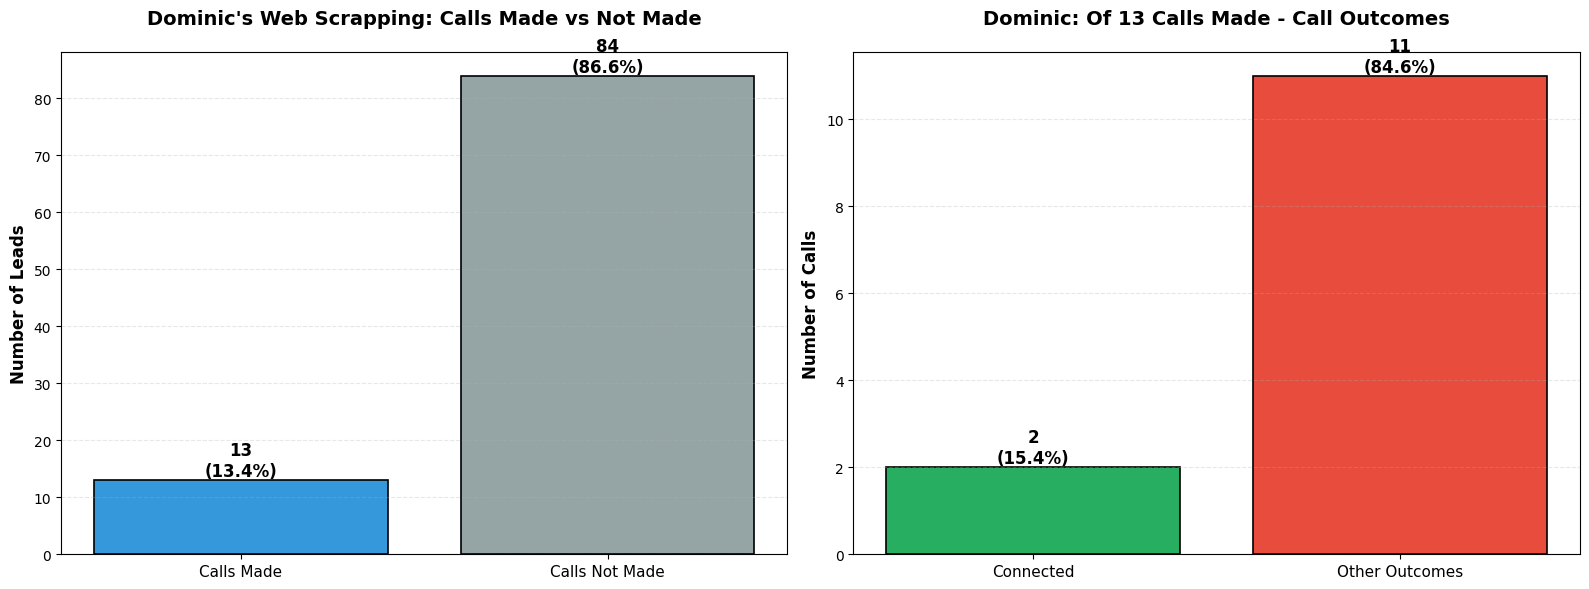

In [10]:
# Analyze Web Scrapping leads for Dominic - Calls Made and Connection Rate (OPTIMIZED)
import matplotlib.pyplot as plt
import numpy as np

# Filter criteria
tele_sales_col = 'Tele Sales Incharge'
marketing_col = 'Marketing Source (Do not fill anything if the leads are from Hubspot, EPOS clients)'
first_call_col = 'Date of the 1st Call'

# Step 1: Filter Master_DB_df for Dominic + Web Scrapping
dominic_web_scrapping = Master_DB_df[
    (Master_DB_df[tele_sales_col] == 'Dominic') &
    (Master_DB_df[marketing_col] == 'Web Scrapping')
].copy()

print(f"=== Dominic's Web Scrapping Lead Analysis ===")
print(f"Total leads for Dominic with Web Scrapping: {len(dominic_web_scrapping)}")

if len(dominic_web_scrapping) > 0:
    total_leads = len(dominic_web_scrapping)

    # Step 2: Separate calls made vs not made based on 'Date of the 1st Call'
    # Handle potential duplicate columns by getting the first occurrence
    first_call_data = dominic_web_scrapping[first_call_col]
    if isinstance(first_call_data, pd.DataFrame):
        first_call_data = first_call_data.iloc[:, 0]
    
    calls_made = dominic_web_scrapping[
        (first_call_data.notna()) &
        (first_call_data.astype(str).str.strip() != '')
    ].copy()

    calls_not_made = dominic_web_scrapping[
        (first_call_data.isna()) |
        (first_call_data.astype(str).str.strip() == '')
    ].copy()

    calls_made_count = len(calls_made)
    calls_not_made_count = len(calls_not_made)

    calls_made_pct = (calls_made_count / total_leads * 100) if total_leads > 0 else 0
    calls_not_made_pct = (calls_not_made_count / total_leads * 100) if total_leads > 0 else 0

    # Step 3: For calls made, analyze Call Outcome
    # Handle potential duplicate columns for Call Outcome
    call_outcome_data = calls_made['Call Outcome']
    if isinstance(call_outcome_data, pd.DataFrame):
        call_outcome_data = call_outcome_data.iloc[:, 0]
    
    # Filter out rows with empty/null Call Outcome
    calls_with_outcome = calls_made[
        (call_outcome_data.notna()) &
        (call_outcome_data.astype(str).str.strip() != '')
    ].copy()

    # Count Connected vs Other outcomes
    outcome_for_counting = calls_with_outcome['Call Outcome']
    if isinstance(outcome_for_counting, pd.DataFrame):
        outcome_for_counting = outcome_for_counting.iloc[:, 0]
    
    connected_count = len(calls_with_outcome[outcome_for_counting == 'Connected'])
    other_outcomes_count = len(calls_with_outcome[outcome_for_counting != 'Connected'])

    connected_pct = (connected_count / calls_made_count * 100) if calls_made_count > 0 else 0
    other_outcomes_pct = (other_outcomes_count / calls_made_count * 100) if calls_made_count > 0 else 0

    # Print summary
    print(f"\n--- Call Status ---")
    print(f"Calls Made: {calls_made_count} ({calls_made_pct:.1f}%)")
    print(f"Calls Not Made: {calls_not_made_count} ({calls_not_made_pct:.1f}%)")

    print(f"\n--- Of {calls_made_count} Calls Made ---")
    print(f"Connected: {connected_count} ({connected_pct:.1f}%)")
    print(f"Other Outcomes: {other_outcomes_count} ({other_outcomes_pct:.1f}%)")

    # Breakdown of other outcomes
    if other_outcomes_count > 0:
        other_outcome_series = calls_with_outcome['Call Outcome']
        if isinstance(other_outcome_series, pd.DataFrame):
            other_outcome_series = other_outcome_series.iloc[:, 0]
        
        other_outcome_breakdown = other_outcome_series[other_outcome_series != 'Connected'].value_counts()
        print(f"\nOther Outcomes Breakdown:")
        for outcome, count in other_outcome_breakdown.items():
            print(f"  {outcome}: {count}")

    # Create visualizations - Two column charts side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Chart 1: Calls Made vs Not Made
    categories1 = ['Calls Made', 'Calls Not Made']
    values1 = [calls_made_count, calls_not_made_count]
    colors1 = ['#3498DB', '#95A5A6']
    bars1 = ax1.bar(categories1, values1, color=colors1, edgecolor='black', linewidth=1.2)

    for bar, val in zip(bars1, values1):
        height = bar.get_height()
        pct = (val / total_leads * 100) if total_leads > 0 else 0
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}\n({pct:.1f}%)',
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

    ax1.set_ylabel('Number of Leads', fontsize=12, fontweight='bold')
    ax1.set_title("Dominic's Web Scrapping: Calls Made vs Not Made", fontsize=14, fontweight='bold', pad=20)
    ax1.tick_params(axis='x', labelsize=11)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')

    # Chart 2: Connected vs Other Outcomes (of calls made)
    categories2 = ['Connected', 'Other Outcomes']
    values2 = [connected_count, other_outcomes_count]
    colors2 = ['#27AE60', '#E74C3C']
    bars2 = ax2.bar(categories2, values2, color=colors2, edgecolor='black', linewidth=1.2)

    for bar, val in zip(bars2, values2):
        height = bar.get_height()
        pct = (val / calls_made_count * 100) if calls_made_count > 0 else 0
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}\n({pct:.1f}%)',
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

    ax2.set_ylabel('Number of Calls', fontsize=12, fontweight='bold')
    ax2.set_title(f"Dominic: Of {calls_made_count} Calls Made - Call Outcomes", fontsize=14, fontweight='bold', pad=20)
    ax2.tick_params(axis='x', labelsize=11)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.show()

else:
    print("No Web Scrapping leads found for Dominic.")

=== Web Scrapping Phone Verification Analysis ===
Total Web Scrapping Leads: 268

Phone Verification Status:
  Verified: 5 (1.87%)
  Not Verified: 7 (2.61%)
  None/Empty: 256 (95.52%)


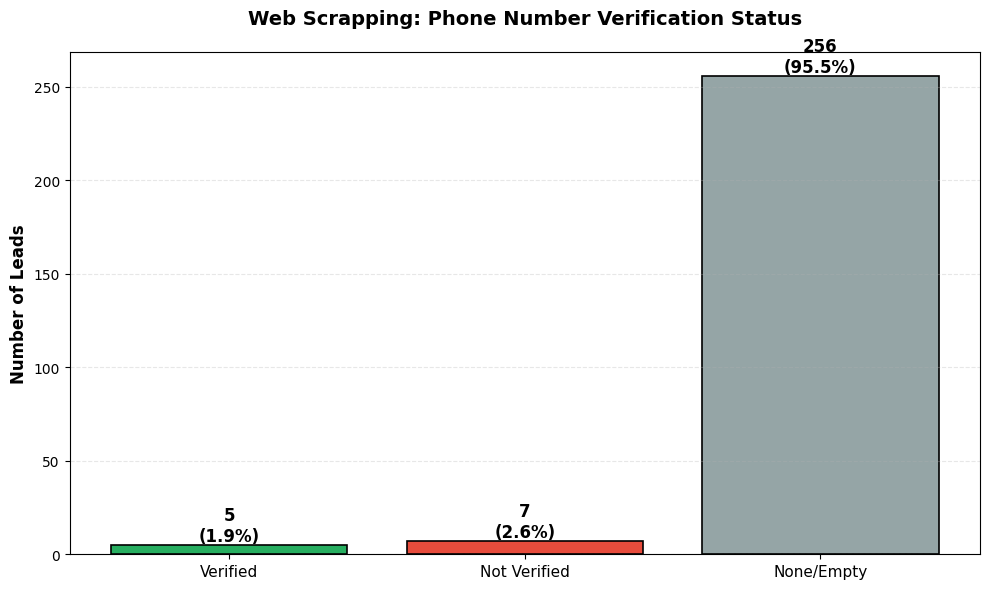


=== Detailed Breakdown ===
Total Web Scrapping Leads: 268

Phone Verification Status:
  - Verified: 5 (1.87%)
  - Not Verified: 7 (2.61%)
  - None/Empty: 256 (95.52%)


In [11]:
# Analyze Phone Number Verification Status for Web Scrapping Leads
import matplotlib.pyplot as plt
import numpy as np

# Count total leads by Marketing Source from Master_DB_df
marketing_col = 'Marketing Source (Do not fill anything if the leads are from Hubspot, EPOS clients)'
source_counts = Master_DB_df[marketing_col].value_counts()

# Filter for Web Scrapping only
web_scrapping_row = source_counts[source_counts.index == 'Web Scrapping']

if not web_scrapping_row.empty:
    total_web_scrapping = web_scrapping_row.values[0]
    
    # Filter Master_DB_df for Web Scrapping leads only
    web_scrapping_leads = Master_DB_df[Master_DB_df[marketing_col] == 'Web Scrapping'].copy()
    
    # Check if 'Phone number Verified ?' column exists
    phone_verified_col = 'Phone number Verified ?'
    
    if phone_verified_col in web_scrapping_leads.columns:
        # Count values in 'Phone number Verified ?' column
        # Handle case-insensitive matching and strip whitespace
        web_scrapping_leads[phone_verified_col] = web_scrapping_leads[phone_verified_col].astype(str).str.strip()
        
        # Count Verified, Not Verified, and None/Empty values
        verified_count = len(web_scrapping_leads[
            web_scrapping_leads[phone_verified_col].str.lower() == 'verified'
        ])
        
        not_verified_count = len(web_scrapping_leads[
            web_scrapping_leads[phone_verified_col].str.lower() == 'not verified'
        ])
        
        none_count = len(web_scrapping_leads[
            (web_scrapping_leads[phone_verified_col].isna()) | 
            (web_scrapping_leads[phone_verified_col] == '') |
            (web_scrapping_leads[phone_verified_col] == 'nan')
        ])
        
        # Calculate percentages
        verified_pct = (verified_count / total_web_scrapping * 100) if total_web_scrapping > 0 else 0
        not_verified_pct = (not_verified_count / total_web_scrapping * 100) if total_web_scrapping > 0 else 0
        none_pct = (none_count / total_web_scrapping * 100) if total_web_scrapping > 0 else 0
        
        print("=== Web Scrapping Phone Verification Analysis ===")
        print(f"Total Web Scrapping Leads: {total_web_scrapping}")
        print(f"\nPhone Verification Status:")
        print(f"  Verified: {verified_count} ({verified_pct:.2f}%)")
        print(f"  Not Verified: {not_verified_count} ({not_verified_pct:.2f}%)")
        print(f"  None/Empty: {none_count} ({none_pct:.2f}%)")
        
        # Create column chart
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        categories = ['Verified', 'Not Verified', 'None/Empty']
        values = [verified_count, not_verified_count, none_count]
        colors = ['#27AE60', '#E74C3C', '#95A5A6']
        
        bars = ax.bar(categories, values, color=colors, edgecolor='black', linewidth=1.2)
        
        # Add value labels on bars
        for i, bar in enumerate(bars):
            height = bar.get_height()
            pct = (height / total_web_scrapping * 100)
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}\n({pct:.1f}%)',
                    ha='center', va='bottom', fontsize=12, fontweight='bold')
        
        ax.set_ylabel('Number of Leads', fontsize=12, fontweight='bold')
        ax.set_title('Web Scrapping: Phone Number Verification Status', fontsize=14, fontweight='bold', pad=20)
        ax.tick_params(axis='x', labelsize=11)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        plt.show()
        
        # Display detailed breakdown
        print(f"\n=== Detailed Breakdown ===")
        print(f"Total Web Scrapping Leads: {total_web_scrapping}")
        print(f"\nPhone Verification Status:")
        print(f"  - Verified: {verified_count} ({verified_pct:.2f}%)")
        print(f"  - Not Verified: {not_verified_count} ({not_verified_pct:.2f}%)")
        print(f"  - None/Empty: {none_count} ({none_pct:.2f}%)")
    else:
        print(f"⚠️ Warning: Column '{phone_verified_col}' not found in Master_DB_df")
        print(f"Available columns: {list(Master_DB_df.columns)}")
else:
    print("⚠️ No 'Web Scrapping' leads found in Master_DB_df")

=== Web Scrapping Lead Analysis - Calls with Verification Status ===
Total Web Scrapping leads: 268
Total calls made: 39

=== Summary ===
Total Calls Made (with verification data): 12
  Verified: 5 (41.7%)
  Not Verified: 7 (58.3%)


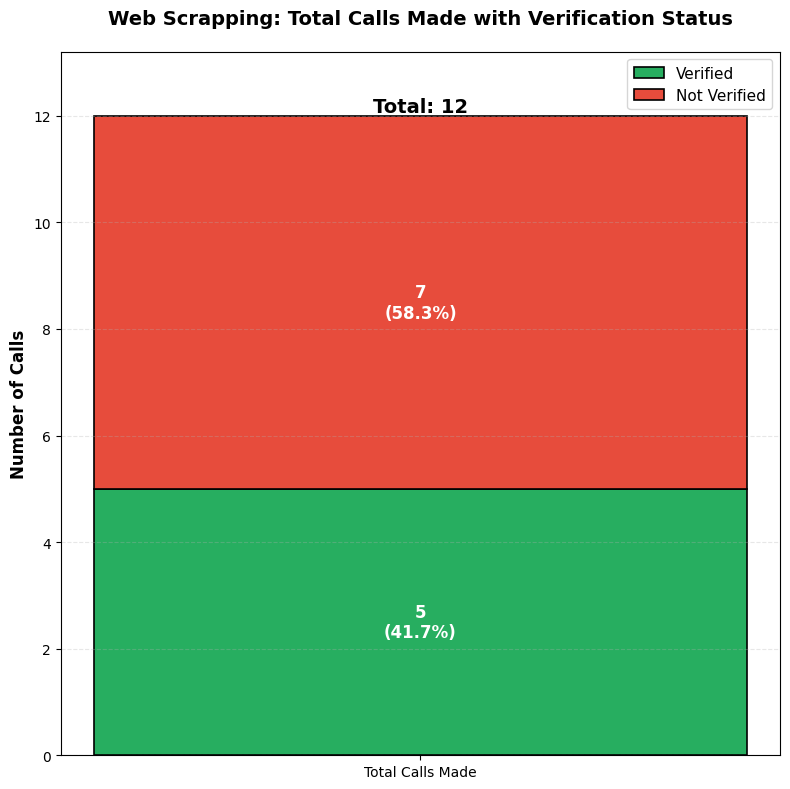

In [21]:
# Analyze Web Scrapping leads - Total Calls with Verification Status (SINGLE STACKED CHART)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Filter criteria
marketing_col = 'Marketing Source (Do not fill anything if the leads are from Hubspot, EPOS clients)'
first_call_col = 'Date of the 1st Call'
phone_verified_col = 'Phone number Verified ?'

# Step 1: Filter Master_DB_df for Web Scrapping only
web_scrapping = Master_DB_df[
    Master_DB_df[marketing_col] == 'Web Scrapping'
].copy()

print(f"=== Web Scrapping Lead Analysis - Calls with Verification Status ===")
print(f"Total Web Scrapping leads: {len(web_scrapping)}")

if len(web_scrapping) > 0:
    # Step 2: Filter for calls made only (where Date of 1st Call is not empty)
    first_call_data = web_scrapping[first_call_col]
    if isinstance(first_call_data, pd.DataFrame):
        first_call_data = first_call_data.iloc[:, 0]
    
    calls_made = web_scrapping[
        (first_call_data.notna()) &
        (first_call_data.astype(str).str.strip() != '')
    ].copy()

    print(f"Total calls made: {len(calls_made)}")

    if len(calls_made) > 0:
        # Step 3: Standardize Phone Verification Status
        if phone_verified_col in calls_made.columns:
            phone_verified_data = calls_made[phone_verified_col]
            if isinstance(phone_verified_data, pd.DataFrame):
                phone_verified_data = phone_verified_data.iloc[:, 0]
            
            calls_made['verification_status'] = phone_verified_data.astype(str).str.strip().str.lower()
            
            # Count Verified and Not Verified only
            verified_count = len(calls_made[calls_made['verification_status'] == 'verified'])
            not_verified_count = len(calls_made[calls_made['verification_status'] == 'not verified'])
        else:
            print(f"⚠️ Warning: Column '{phone_verified_col}' not found")
            verified_count = 0
            not_verified_count = 0
        
        total_calls = verified_count + not_verified_count
        
        # Calculate percentages
        verified_pct = (verified_count / total_calls * 100) if total_calls > 0 else 0
        not_verified_pct = (not_verified_count / total_calls * 100) if total_calls > 0 else 0
        
        print(f"\n=== Summary ===")
        print(f"Total Calls Made (with verification data): {total_calls}")
        print(f"  Verified: {verified_count} ({verified_pct:.1f}%)")
        print(f"  Not Verified: {not_verified_count} ({not_verified_pct:.1f}%)")
        
        # Step 4: Create single stacked bar chart
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        
        # Single stacked bar
        categories = ['Total Calls Made']
        verified = [verified_count]
        not_verified = [not_verified_count]
        
        # Create stacked bar
        bar1 = ax.bar(categories, verified, color='#27AE60', edgecolor='black', linewidth=1.2, label='Verified')
        bar2 = ax.bar(categories, not_verified, bottom=verified, color='#E74C3C', edgecolor='black', linewidth=1.2, label='Not Verified')
        
        # Add value labels on each segment
        # Verified segment
        if verified_count > 0:
            ax.text(0, verified_count/2, f'{verified_count}\n({verified_pct:.1f}%)',
                   ha='center', va='center', fontsize=12, fontweight='bold', color='white')
        
        # Not Verified segment
        if not_verified_count > 0:
            ax.text(0, verified_count + not_verified_count/2, f'{not_verified_count}\n({not_verified_pct:.1f}%)',
                   ha='center', va='center', fontsize=12, fontweight='bold', color='white')
        
        # Total on top
        ax.text(0, total_calls, f'Total: {total_calls}',
               ha='center', va='bottom', fontsize=14, fontweight='bold')
        
        ax.set_ylabel('Number of Calls', fontsize=12, fontweight='bold')
        ax.set_title('Web Scrapping: Total Calls Made with Verification Status', 
                    fontsize=14, fontweight='bold', pad=20)
        ax.legend(loc='upper right', fontsize=11)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.set_ylim(0, total_calls * 1.1)
        
        plt.tight_layout()
        plt.show()
        
    else:
        print("No calls have been made yet.")
        
else:
    print("No Web Scrapping leads found.")

### Analyze all MR 

Found 11 Market Researchers in Master_DB_df

=== Hazim's Market Research Lead Analysis ===
Total Market Research Leads: 2353

Calls Status:
  Calls Made: 802 (34.08%)
  Calls Not Made: 1551 (65.92%)

Of the 802 calls made:
  Calls with Outcome: 770
  Calls with NULL Outcome: 32

Of the 770 calls with outcome:
  Connected: 249 (32.34%)
  Not Connected: 521 (67.66%)


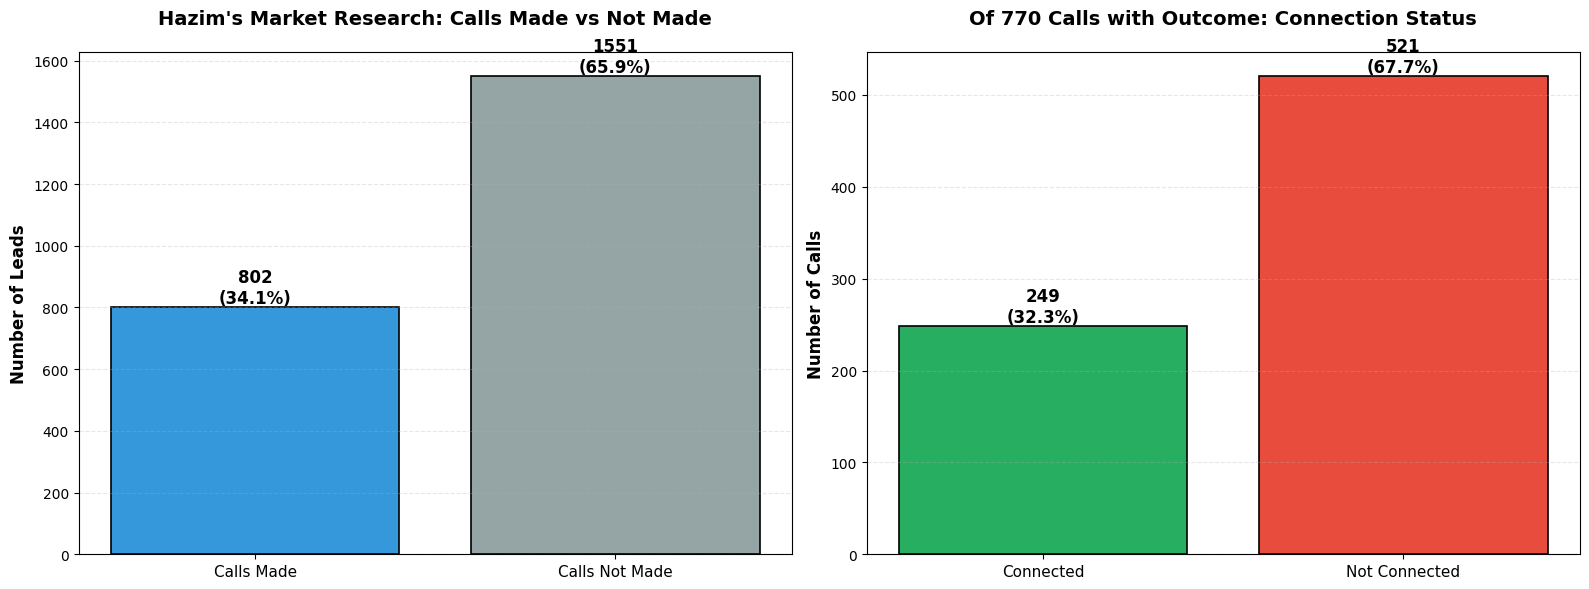


=== Jasmin's Market Research Lead Analysis ===
Total Market Research Leads: 1918

Calls Status:
  Calls Made: 779 (40.62%)
  Calls Not Made: 1139 (59.38%)

Of the 779 calls made:
  Calls with Outcome: 769
  Calls with NULL Outcome: 10

Of the 769 calls with outcome:
  Connected: 180 (23.41%)
  Not Connected: 589 (76.59%)


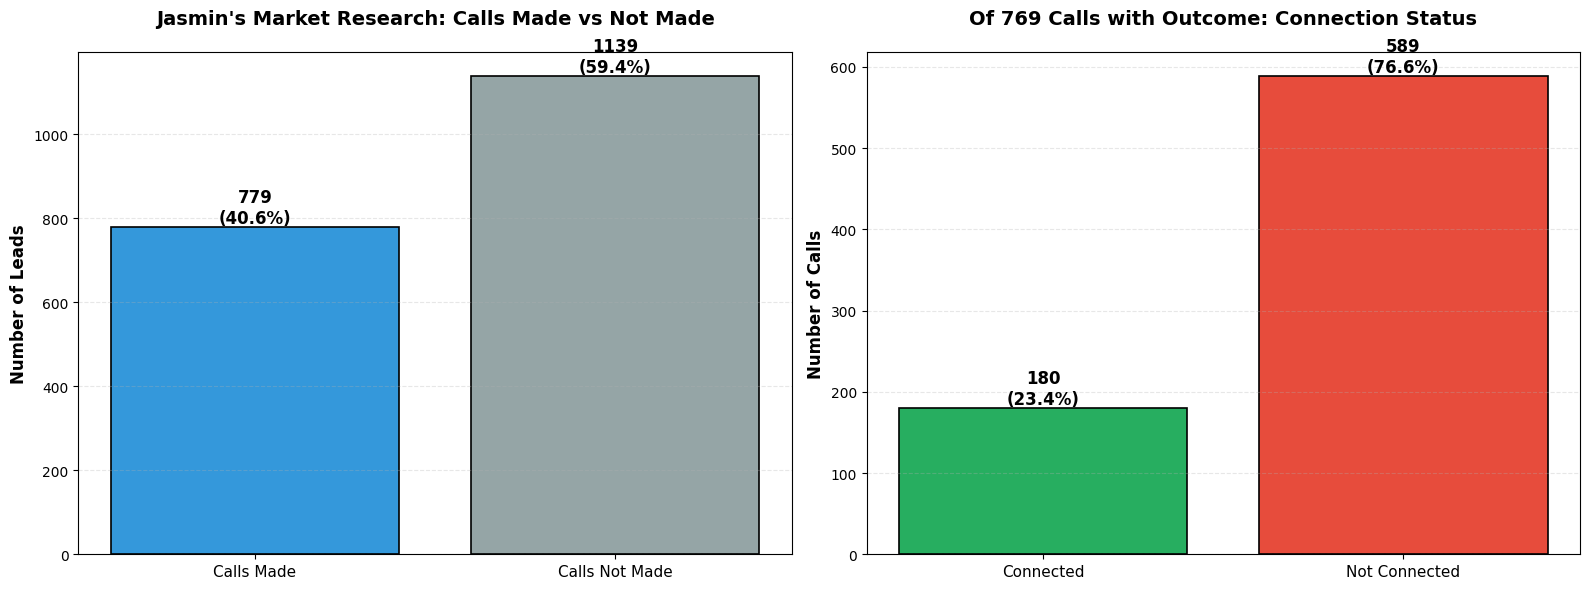


=== Kai Xin's Market Research Lead Analysis ===
Total Market Research Leads: 315

Calls Status:
  Calls Made: 256 (81.27%)
  Calls Not Made: 59 (18.73%)

Of the 256 calls made:
  Calls with Outcome: 254
  Calls with NULL Outcome: 2

Of the 254 calls with outcome:
  Connected: 47 (18.50%)
  Not Connected: 207 (81.50%)


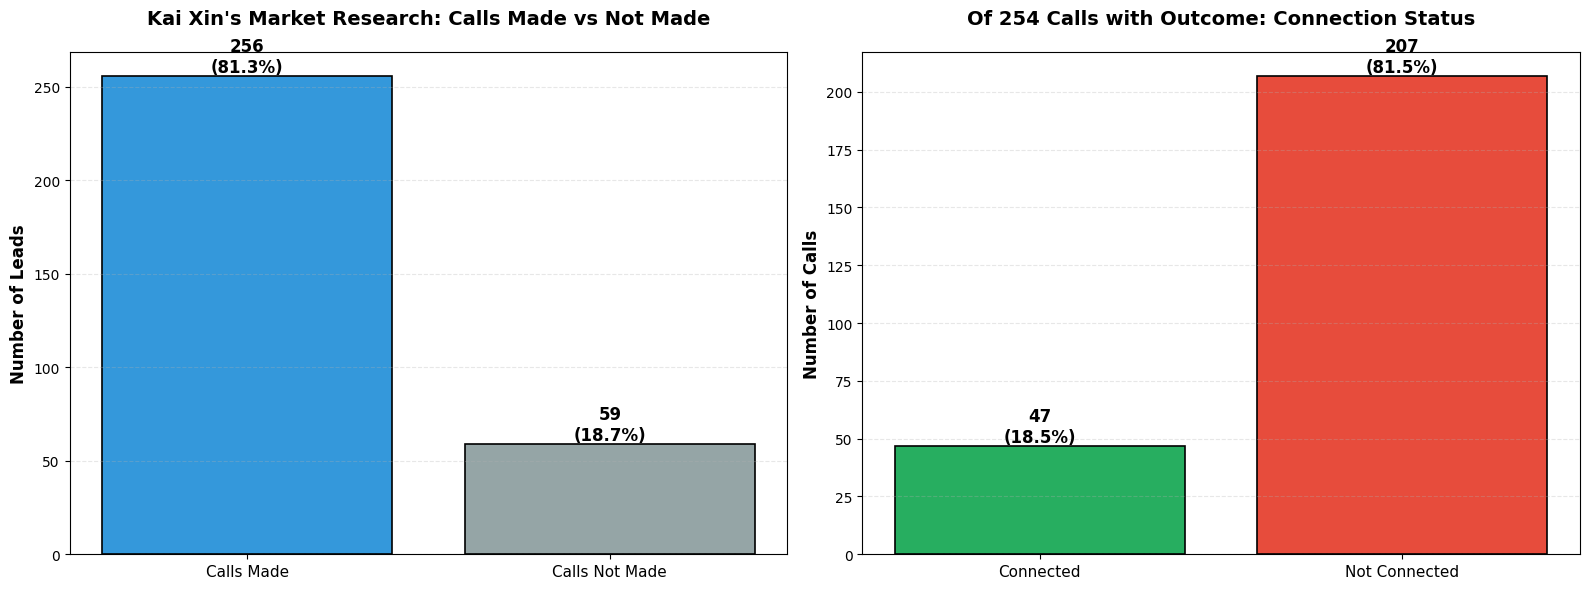


=== Kalaivani's Market Research Lead Analysis ===
Total Market Research Leads: 1458

Calls Status:
  Calls Made: 757 (51.92%)
  Calls Not Made: 701 (48.08%)

Of the 757 calls made:
  Calls with Outcome: 752
  Calls with NULL Outcome: 5

Of the 752 calls with outcome:
  Connected: 166 (22.07%)
  Not Connected: 586 (77.93%)


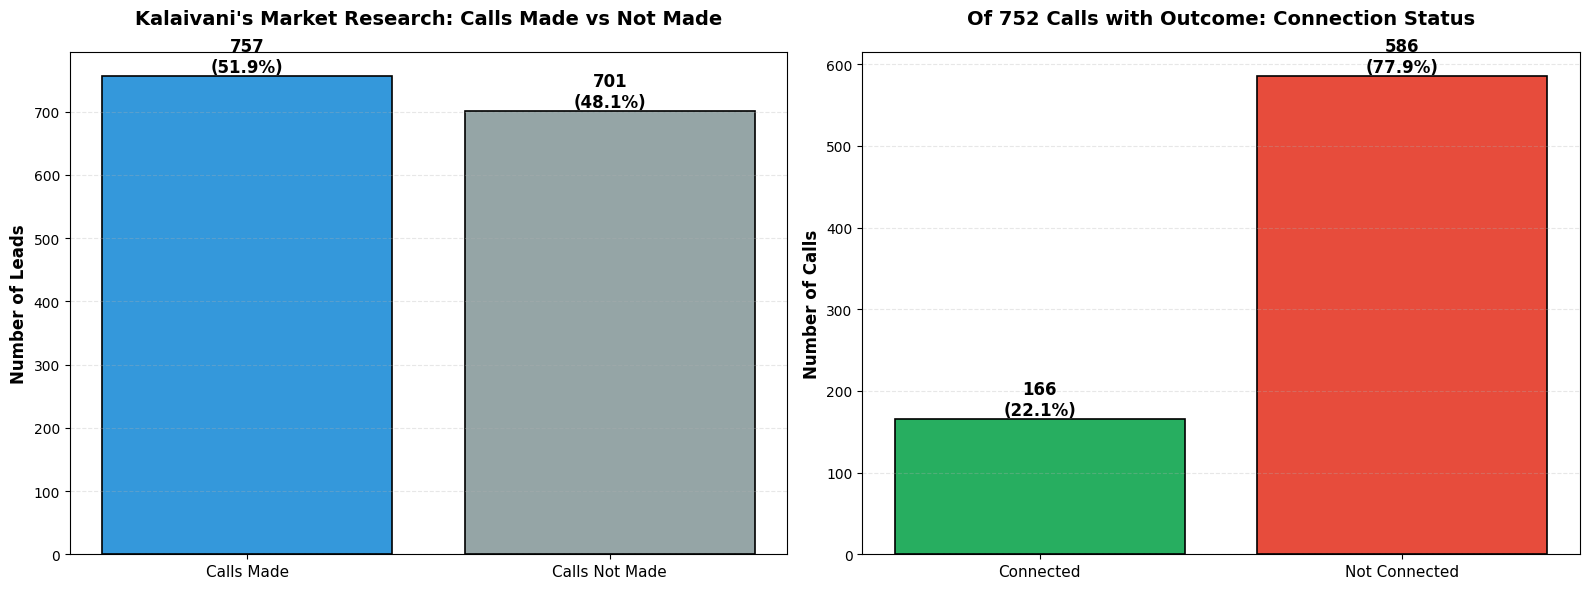


=== Khairunnisa's Market Research Lead Analysis ===
Total Market Research Leads: 1443

Calls Status:
  Calls Made: 537 (37.21%)
  Calls Not Made: 906 (62.79%)

Of the 537 calls made:
  Calls with Outcome: 528
  Calls with NULL Outcome: 9

Of the 528 calls with outcome:
  Connected: 145 (27.46%)
  Not Connected: 383 (72.54%)


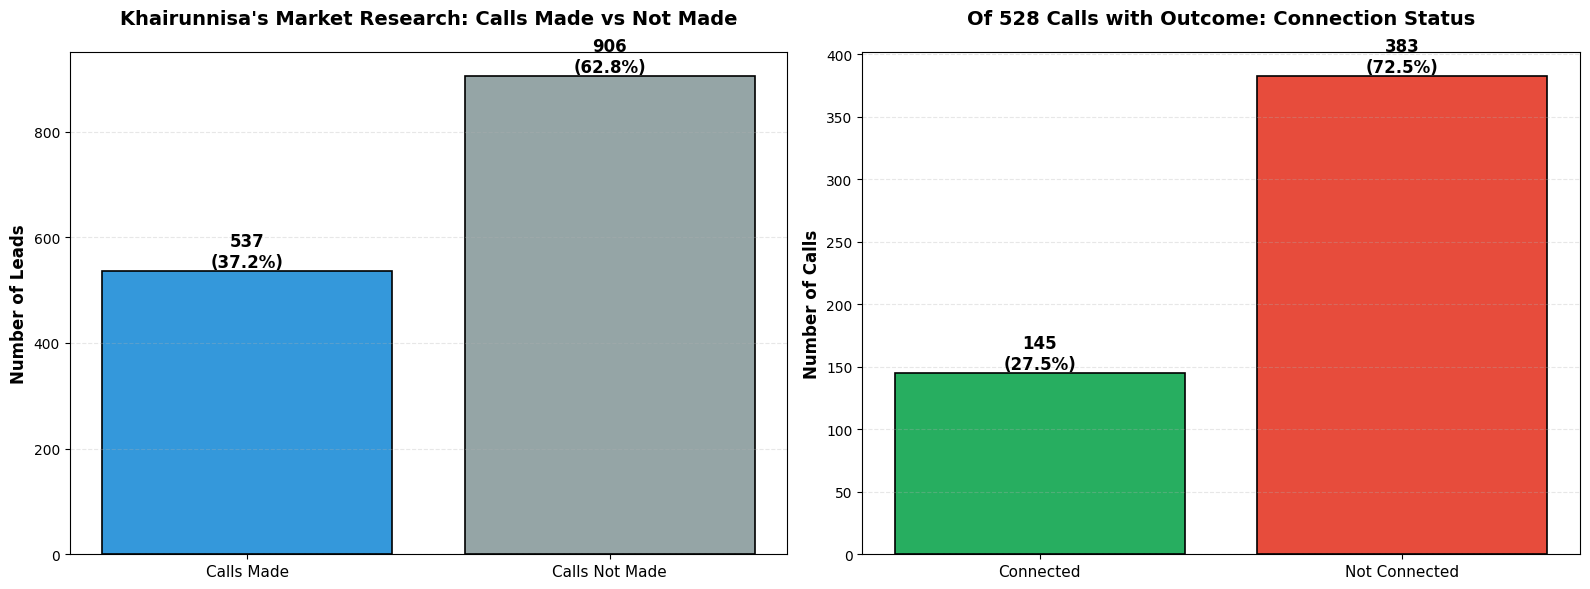


=== Nabihah's Market Research Lead Analysis ===
Total Market Research Leads: 870

Calls Status:
  Calls Made: 547 (62.87%)
  Calls Not Made: 323 (37.13%)

Of the 547 calls made:
  Calls with Outcome: 542
  Calls with NULL Outcome: 5

Of the 542 calls with outcome:
  Connected: 122 (22.51%)
  Not Connected: 420 (77.49%)


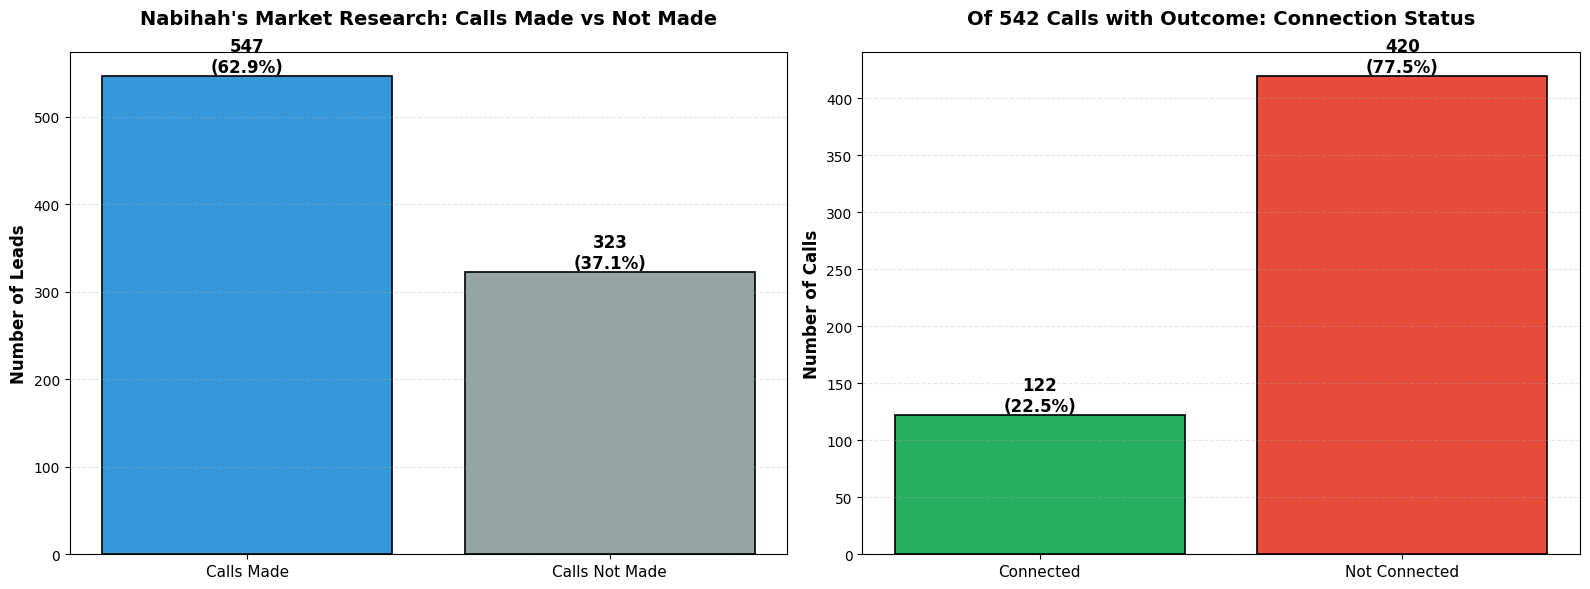


=== Peng Tee's Market Research Lead Analysis ===
Total Market Research Leads: 1428

Calls Status:
  Calls Made: 414 (28.99%)
  Calls Not Made: 1014 (71.01%)

Of the 414 calls made:
  Calls with Outcome: 378
  Calls with NULL Outcome: 36

Of the 378 calls with outcome:
  Connected: 91 (24.07%)
  Not Connected: 287 (75.93%)


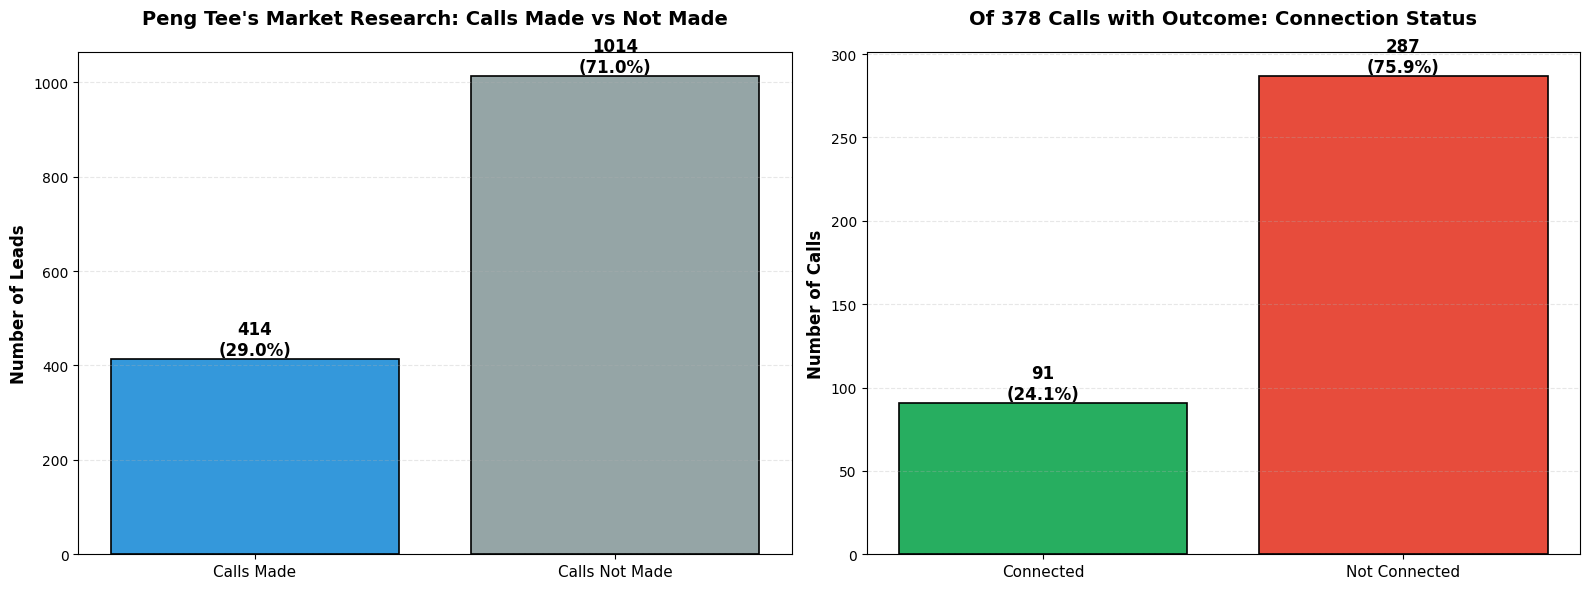


=== Shafiqah's Market Research Lead Analysis ===
Total Market Research Leads: 1697

Calls Status:
  Calls Made: 614 (36.18%)
  Calls Not Made: 1083 (63.82%)

Of the 614 calls made:
  Calls with Outcome: 600
  Calls with NULL Outcome: 14

Of the 600 calls with outcome:
  Connected: 140 (23.33%)
  Not Connected: 460 (76.67%)


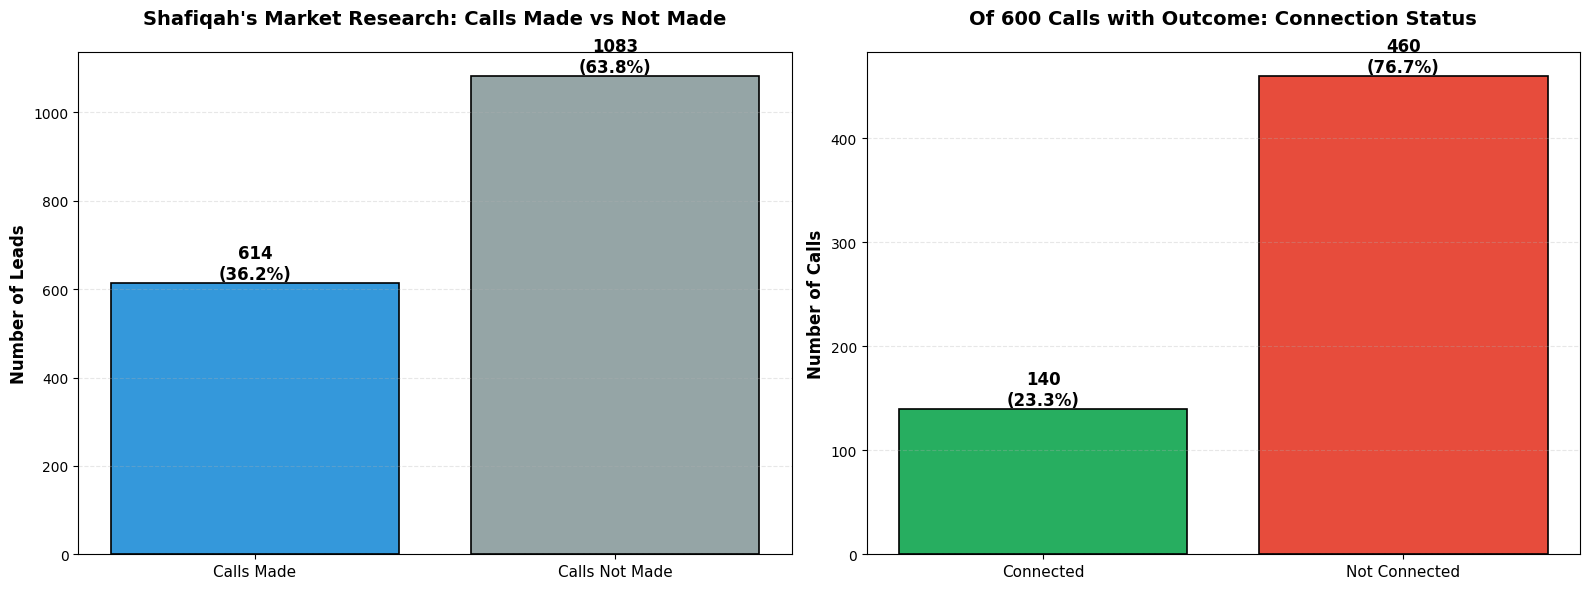


=== Suen Xemin's Market Research Lead Analysis ===
Total Market Research Leads: 1151

Calls Status:
  Calls Made: 367 (31.89%)
  Calls Not Made: 784 (68.11%)

Of the 367 calls made:
  Calls with Outcome: 353
  Calls with NULL Outcome: 14

Of the 353 calls with outcome:
  Connected: 73 (20.68%)
  Not Connected: 280 (79.32%)


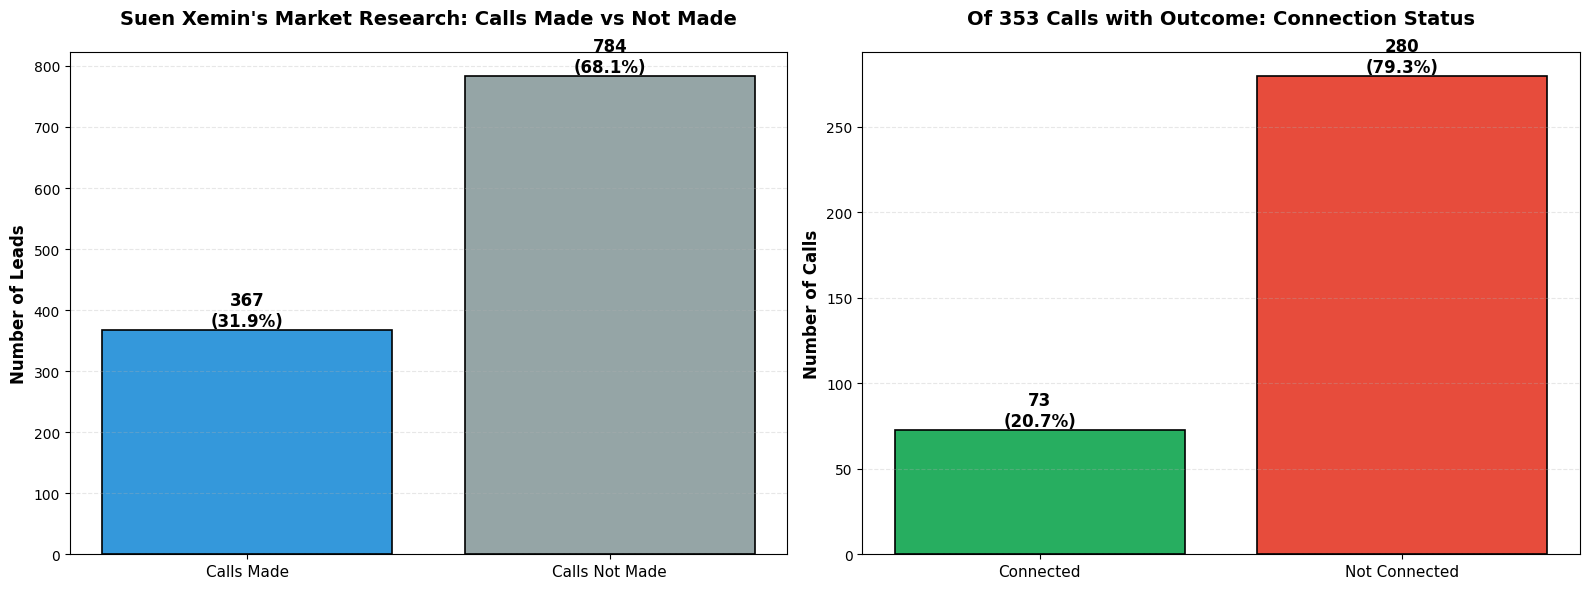


=== Yasin's Market Research Lead Analysis ===
Total Market Research Leads: 1334

Calls Status:
  Calls Made: 267 (20.01%)
  Calls Not Made: 1067 (79.99%)

Of the 267 calls made:
  Calls with Outcome: 246
  Calls with NULL Outcome: 21

Of the 246 calls with outcome:
  Connected: 86 (34.96%)
  Not Connected: 160 (65.04%)


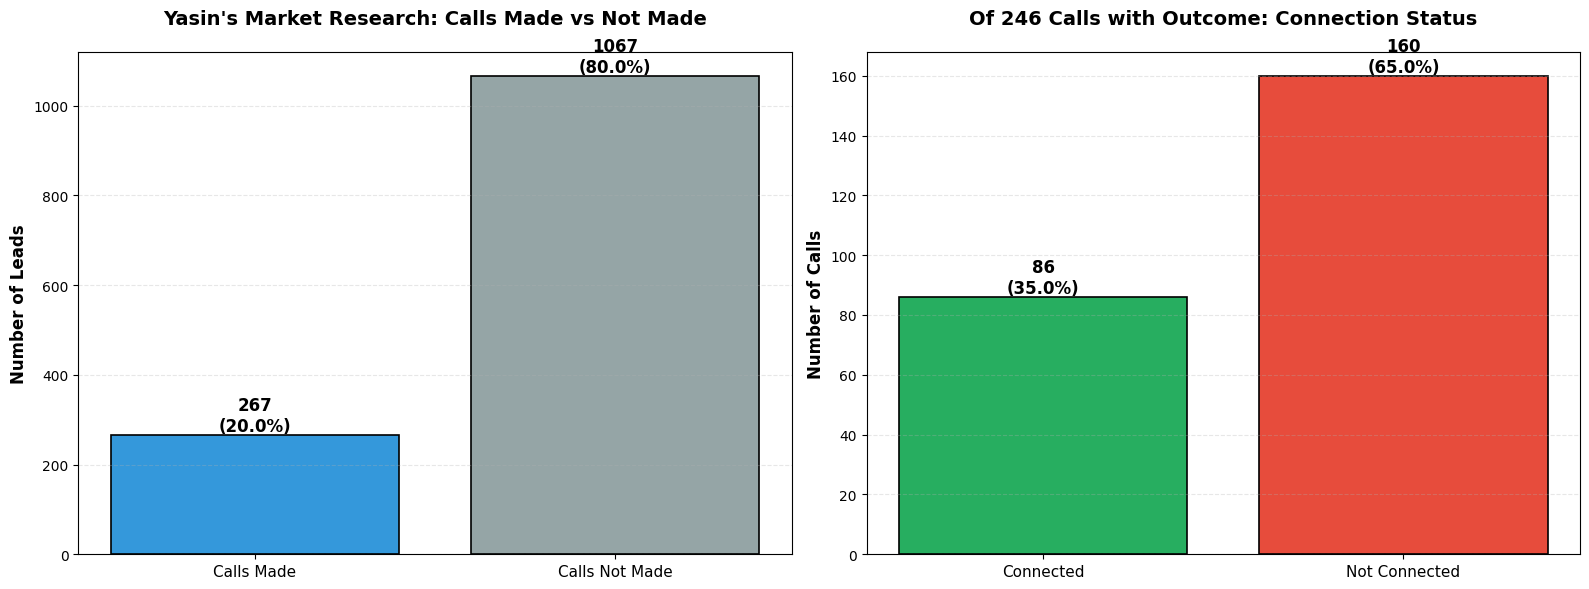


Analysis complete for all Market Researchers (from Master_DB_df)


In [13]:
# Analyze ALL Market Researchers from Master_DB_df - Calls Made and Connection Rate


researcher_col = 'Name of the Market Researcher'
first_call_col = 'Date of the 1st Call'

# Get all unique Market Researchers from Master_DB_df
all_researchers = Master_DB_df[researcher_col].unique()

print(f"Found {len(all_researchers)} Market Researchers in Master_DB_df")

# Check for duplicate columns
duplicate_check = Master_DB_df.columns[Master_DB_df.columns == first_call_col]
if len(duplicate_check) > 1:
    print(f"\n⚠️ WARNING: Found {len(duplicate_check)} columns named '{first_call_col}'!")
    print("Using the first occurrence only.")
    # Get the index of the first occurrence
    first_call_idx = Master_DB_df.columns.get_loc(first_call_col)
    if isinstance(first_call_idx, slice):
        first_call_idx = first_call_idx.start
    elif isinstance(first_call_idx, np.ndarray):
        first_call_idx = np.where(first_call_idx)[0][0]

print("=" * 80)

# Loop through each researcher
for researcher_name in sorted(all_researchers):
    if pd.isna(researcher_name) or str(researcher_name).strip() == '':
        continue
    
    # Filter for this specific researcher
    researcher_leads = Master_DB_df[Master_DB_df[researcher_col] == researcher_name].copy()
    
    total_leads = len(researcher_leads)
    
    if total_leads > 0:
        # Calls made = leads where 'Date of 1st Call' has a value
        # Use iloc to get the first column if there are duplicates
        if len(duplicate_check) > 1:
            first_call_series = researcher_leads.iloc[:, first_call_idx]
        else:
            first_call_series = researcher_leads[first_call_col]
        
        # Ensure it's a Series
        if isinstance(first_call_series, pd.DataFrame):
            first_call_series = first_call_series.iloc[:, 0]
            
        mask_notna = first_call_series.notna()
        mask_not_empty = first_call_series.astype(str).str.strip() != ''
        calls_made = researcher_leads[mask_notna & mask_not_empty].copy()
        
        calls_made_count = len(calls_made)
        calls_made_pct = (calls_made_count / total_leads * 100) if total_leads > 0 else 0
        calls_not_made_count = total_leads - calls_made_count
        calls_not_made_pct = 100 - calls_made_pct
        
        # Filter to only calls with non-NULL Call Outcome
        outcome_series = calls_made['Call Outcome']
        if isinstance(outcome_series, pd.DataFrame):
            outcome_series = outcome_series.iloc[:, 0]
            
        outcome_mask_notna = outcome_series.notna()
        outcome_mask_not_empty = outcome_series.astype(str).str.strip() != ''
        calls_with_outcome = calls_made[outcome_mask_notna & outcome_mask_not_empty].copy()
        
        # Of the calls with outcome, count how many are connected vs not connected
        connected_from_calls_count = len(calls_with_outcome[calls_with_outcome['Call Outcome'] == 'Connected'])
        not_connected_from_calls_count = len(calls_with_outcome[calls_with_outcome['Call Outcome'] != 'Connected'])
        
        # Calculate percentages based on calls with outcome
        calls_with_outcome_count = len(calls_with_outcome)
        connected_from_calls_pct = (connected_from_calls_count / calls_with_outcome_count * 100) if calls_with_outcome_count > 0 else 0
        not_connected_from_calls_pct = (not_connected_from_calls_count / calls_with_outcome_count * 100) if calls_with_outcome_count > 0 else 0
        
        print(f"\n{'='*80}")
        print(f"=== {researcher_name}'s Market Research Lead Analysis ===")
        print(f"{'='*80}")
        print(f"Total Market Research Leads: {total_leads}")
        print(f"\nCalls Status:")
        print(f"  Calls Made: {calls_made_count} ({calls_made_pct:.2f}%)")
        print(f"  Calls Not Made: {calls_not_made_count} ({calls_not_made_pct:.2f}%)")
        print(f"\nOf the {calls_made_count} calls made:")
        print(f"  Calls with Outcome: {calls_with_outcome_count}")
        print(f"  Calls with NULL Outcome: {calls_made_count - calls_with_outcome_count}")
        print(f"\nOf the {calls_with_outcome_count} calls with outcome:")
        print(f"  Connected: {connected_from_calls_count} ({connected_from_calls_pct:.2f}%)")
        print(f"  Not Connected: {not_connected_from_calls_count} ({not_connected_from_calls_pct:.2f}%)")
        
        # Create a figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Chart 1: Calls Made vs Not Made
        categories1 = ['Calls Made', 'Calls Not Made']
        values1 = [calls_made_count, calls_not_made_count]
        colors1 = ['#3498DB', '#95A5A6']
        bars1 = ax1.bar(categories1, values1, 
                        color=colors1, edgecolor='black', linewidth=1.2)
        
        # Add value labels on bars
        for i, bar in enumerate(bars1):
            height = bar.get_height()
            pct = (height / total_leads * 100)
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                     f'{int(height)}\n({pct:.1f}%)',
                     ha='center', va='bottom', fontsize=12, fontweight='bold')
        
        ax1.set_ylabel('Number of Leads', fontsize=12, fontweight='bold')
        ax1.set_title(f"{researcher_name}'s Market Research: Calls Made vs Not Made", fontsize=14, fontweight='bold', pad=20)
        ax1.tick_params(axis='x', labelsize=11)
        ax1.grid(axis='y', alpha=0.3, linestyle='--')
        
        # Chart 2: Of Calls with Outcome - Connected vs Not Connected
        categories2 = ['Connected', 'Not Connected']
        values2 = [connected_from_calls_count, not_connected_from_calls_count]
        colors2 = ['#27AE60', '#E74C3C']
        bars2 = ax2.bar(categories2, values2, 
                        color=colors2, edgecolor='black', linewidth=1.2)
        
        # Add value labels on bars
        for i, bar in enumerate(bars2):
            height = bar.get_height()
            if calls_with_outcome_count > 0:
                pct = (height / calls_with_outcome_count * 100)
                ax2.text(bar.get_x() + bar.get_width()/2., height,
                         f'{int(height)}\n({pct:.1f}%)',
                         ha='center', va='bottom', fontsize=12, fontweight='bold')
        
        ax2.set_ylabel('Number of Calls', fontsize=12, fontweight='bold')
        ax2.set_title(f'Of {calls_with_outcome_count} Calls with Outcome: Connection Status', fontsize=14, fontweight='bold', pad=20)
        ax2.tick_params(axis='x', labelsize=11)
        ax2.grid(axis='y', alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        plt.show()

print(f"\n{'='*80}")
print("Analysis complete for all Market Researchers (from Master_DB_df)")
print(f"{'='*80}")

=== Market Research Data Summary ===
Total Rows Across All Researchers: 13968

Breakdown by Researcher:
Hazim: 2353 rows (16.8%)
Jasmin: 1918 rows (13.7%)
Shafiqah: 1697 rows (12.1%)
Kalaivani: 1458 rows (10.4%)
Khairunnisa: 1443 rows (10.3%)
Peng Tee: 1428 rows (10.2%)
Yasin: 1334 rows (9.6%)
Suen Xemin: 1151 rows (8.2%)
Nabihah: 870 rows (6.2%)
Kai Xin: 315 rows (2.3%)
: 1 rows (0.0%)


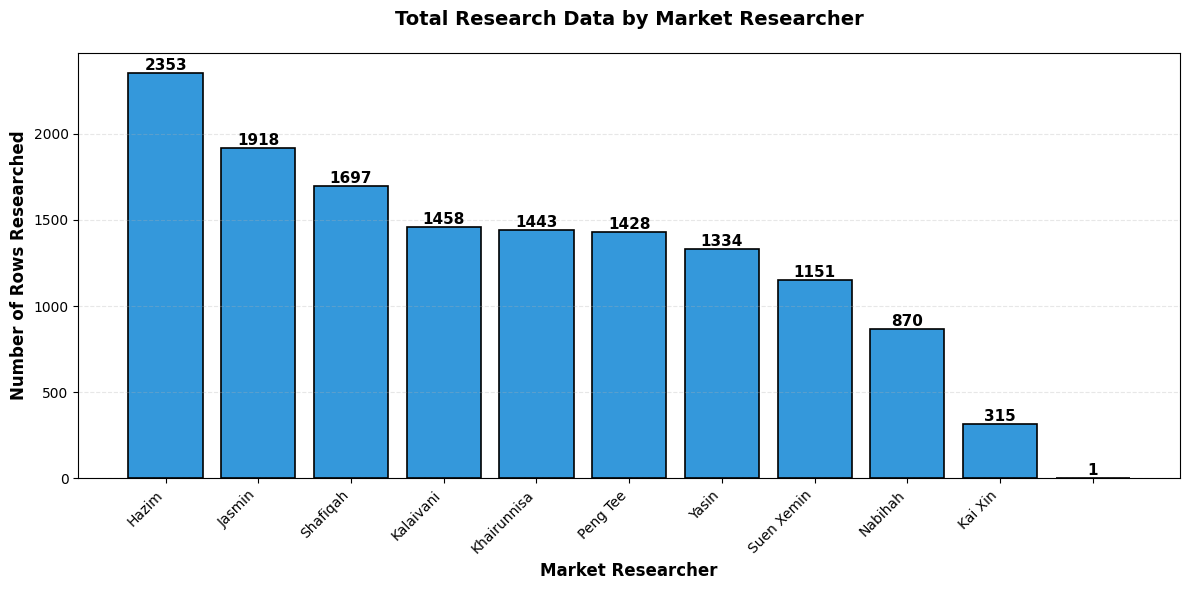

In [14]:
# Count rows by 'Name of the Market Researcher' column from combined dataframe
researcher_counts = Master_DB_df['Name of the Market Researcher'].value_counts().sort_values(ascending=False)

# Convert to DataFrame for easier plotting
count_df = pd.DataFrame({
    'Researcher': researcher_counts.index,
    'Rows_Researched': researcher_counts.values
})

# Create column chart
plt.figure(figsize=(12, 6))
bars = plt.bar(count_df["Researcher"], count_df["Rows_Researched"], 
               color='#3498DB', edgecolor='black', linewidth=1.2)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xlabel('Market Researcher', fontsize=12, fontweight='bold')
plt.ylabel('Number of Rows Researched', fontsize=12, fontweight='bold')
plt.title('Total Research Data by Market Researcher', fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()

# Display summary statistics
print("=== Market Research Data Summary ===")
print(f"Total Rows Across All Researchers: {count_df['Rows_Researched'].sum()}")
print(f"\nBreakdown by Researcher:")
for _, row in count_df.iterrows():
    percentage = (row['Rows_Researched'] / count_df['Rows_Researched'].sum()) * 100
    print(f"{row['Researcher']}: {row['Rows_Researched']} rows ({percentage:.1f}%)")

plt.show()


=== Connected Calls Summary ===
Total Connected Calls: 1299

Breakdown by Researcher:
Hazim: 249 calls (19.2%)
Jasmin: 180 calls (13.9%)
Kalaivani: 166 calls (12.8%)
Khairunnisa: 145 calls (11.2%)
Shafiqah: 139 calls (10.7%)
Nabihah: 122 calls (9.4%)
Peng Tee: 91 calls (7.0%)
Yasin: 86 calls (6.6%)
Suen Xemin: 73 calls (5.6%)
Kai Xin: 48 calls (3.7%)


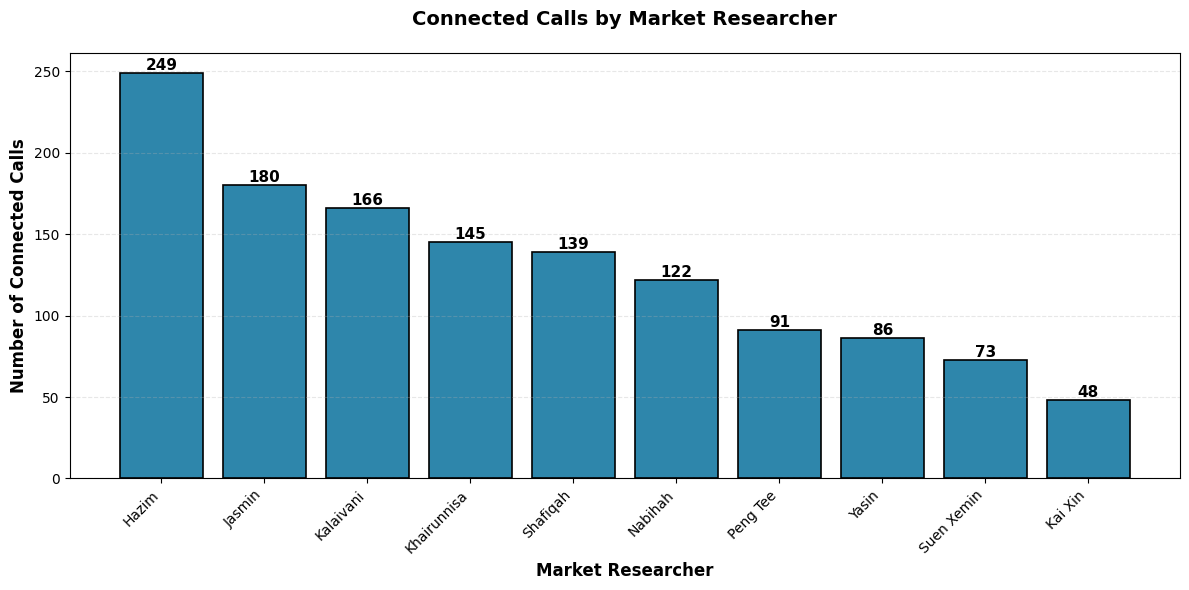

In [15]:
# Filter data where Call Outcome is 'Connected'
connected_calls = combined_researcher_df[combined_researcher_df['Call Outcome'] == 'Connected']

# Count connected calls by researcher
researcher_connected_counts = connected_calls['Name of the Market Researcher'].value_counts().sort_values(ascending=False)

# Create column chart
plt.figure(figsize=(12, 6))
bars = plt.bar(researcher_connected_counts.index, researcher_connected_counts.values, color='#2E86AB', edgecolor='black', linewidth=1.2)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xlabel('Market Researcher', fontsize=12, fontweight='bold')
plt.ylabel('Number of Connected Calls', fontsize=12, fontweight='bold')
plt.title('Connected Calls by Market Researcher', fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()

# Display summary statistics
print("\n=== Connected Calls Summary ===")
print(f"Total Connected Calls: {len(connected_calls)}")
print(f"\nBreakdown by Researcher:")
for researcher, count in researcher_connected_counts.items():
    percentage = (count / len(connected_calls)) * 100
    print(f"{researcher}: {count} calls ({percentage:.1f}%)")

plt.show()

=== Lead Source Analysis ===
Market Research: 9792 total leads | 1296 connected (13.24%)
Web Scrapping: 378 total leads | 3 connected (0.79%)


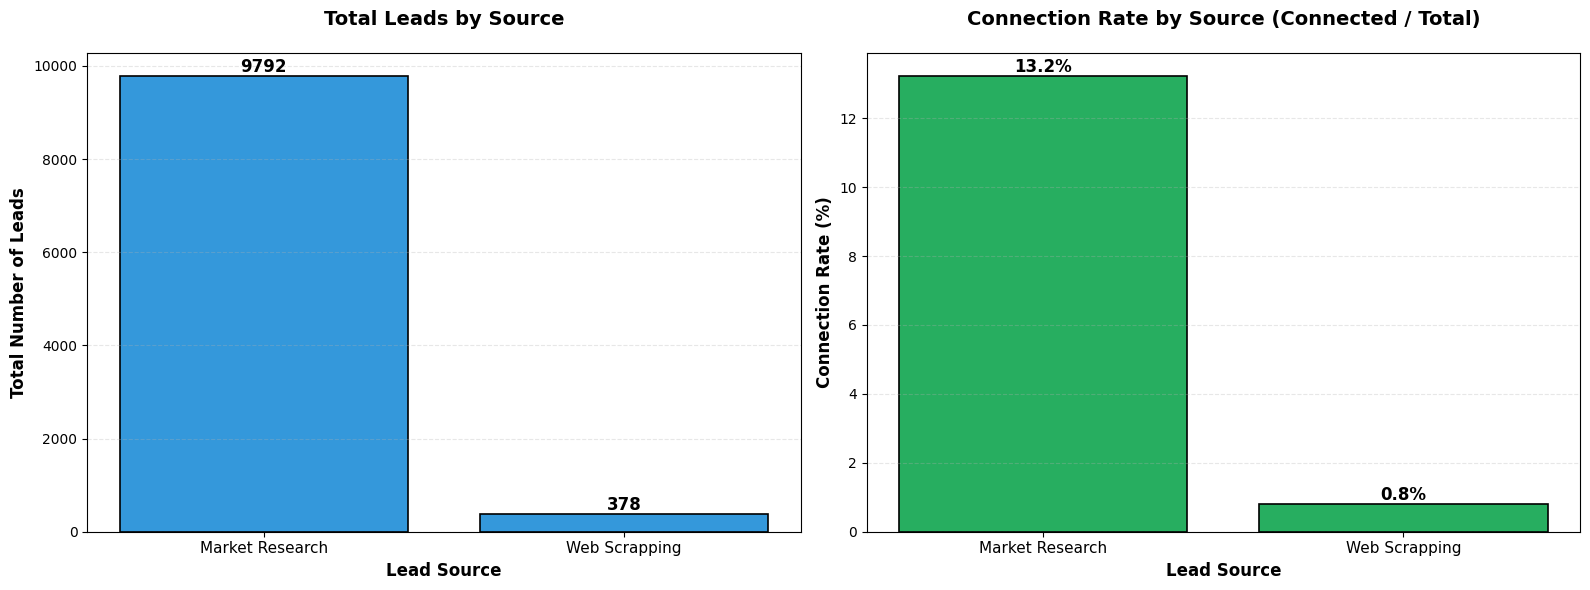


=== Detailed Breakdown ===
Total Leads Across All Sources: 10170
Total Connected Calls: 1299
Overall Connection Rate: 12.77%


In [16]:
# Analyze leads by Source: Market Research vs Web Scraping
import matplotlib.pyplot as plt
import numpy as np

# Count total leads by Source
source_counts = combined_researcher_df['Source'].value_counts()

# Count connected calls by Source
connected_by_source = combined_researcher_df[combined_researcher_df['Call Outcome'] == 'Connected'].groupby('Source').size()

# Create summary dataframe
source_summary = pd.DataFrame({
    'Source': source_counts.index,
    'Total_Leads': source_counts.values
})

# Add connected counts
source_summary['Connected'] = source_summary['Source'].map(connected_by_source).fillna(0).astype(int)

# Calculate connection percentage
source_summary['Connection_Rate'] = (source_summary['Connected'] / source_summary['Total_Leads']) * 100

# Sort by total leads
source_summary = source_summary.sort_values('Total_Leads', ascending=False)

print("=== Lead Source Analysis ===")
for _, row in source_summary.iterrows():
    print(f"{row['Source']}: {row['Total_Leads']} total leads | {row['Connected']} connected ({row['Connection_Rate']:.2f}%)")

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: Total Leads by Source
bars1 = ax1.bar(source_summary['Source'], source_summary['Total_Leads'], 
                color='#3498DB', edgecolor='black', linewidth=1.2)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

ax1.set_xlabel('Lead Source', fontsize=12, fontweight='bold')
ax1.set_ylabel('Total Number of Leads', fontsize=12, fontweight='bold')
ax1.set_title('Total Leads by Source', fontsize=14, fontweight='bold', pad=20)
ax1.tick_params(axis='x', labelsize=11)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Chart 2: Connection Rate (%) by Source
bars2 = ax2.bar(source_summary['Source'], source_summary['Connection_Rate'], 
                color='#27AE60', edgecolor='black', linewidth=1.2)

# Add percentage labels on bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

ax2.set_xlabel('Lead Source', fontsize=12, fontweight='bold')
ax2.set_ylabel('Connection Rate (%)', fontsize=12, fontweight='bold')
ax2.set_title('Connection Rate by Source (Connected / Total)', fontsize=14, fontweight='bold', pad=20)
ax2.tick_params(axis='x', labelsize=11)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Display detailed breakdown
print(f"\n=== Detailed Breakdown ===")
print(f"Total Leads Across All Sources: {source_summary['Total_Leads'].sum()}")
print(f"Total Connected Calls: {source_summary['Connected'].sum()}")
print(f"Overall Connection Rate: {(source_summary['Connected'].sum() / source_summary['Total_Leads'].sum()) * 100:.2f}%")

=== Web Scrapping Lead Analysis ===
Total Web Scrapping Leads: 268

Calls Status:
  Calls Made: 39 (14.55%)
  Calls Not Made: 229 (85.45%)

Of the 39 calls made:
  Connected: 3 (7.69%)
  Not Connected: 36 (92.31%)


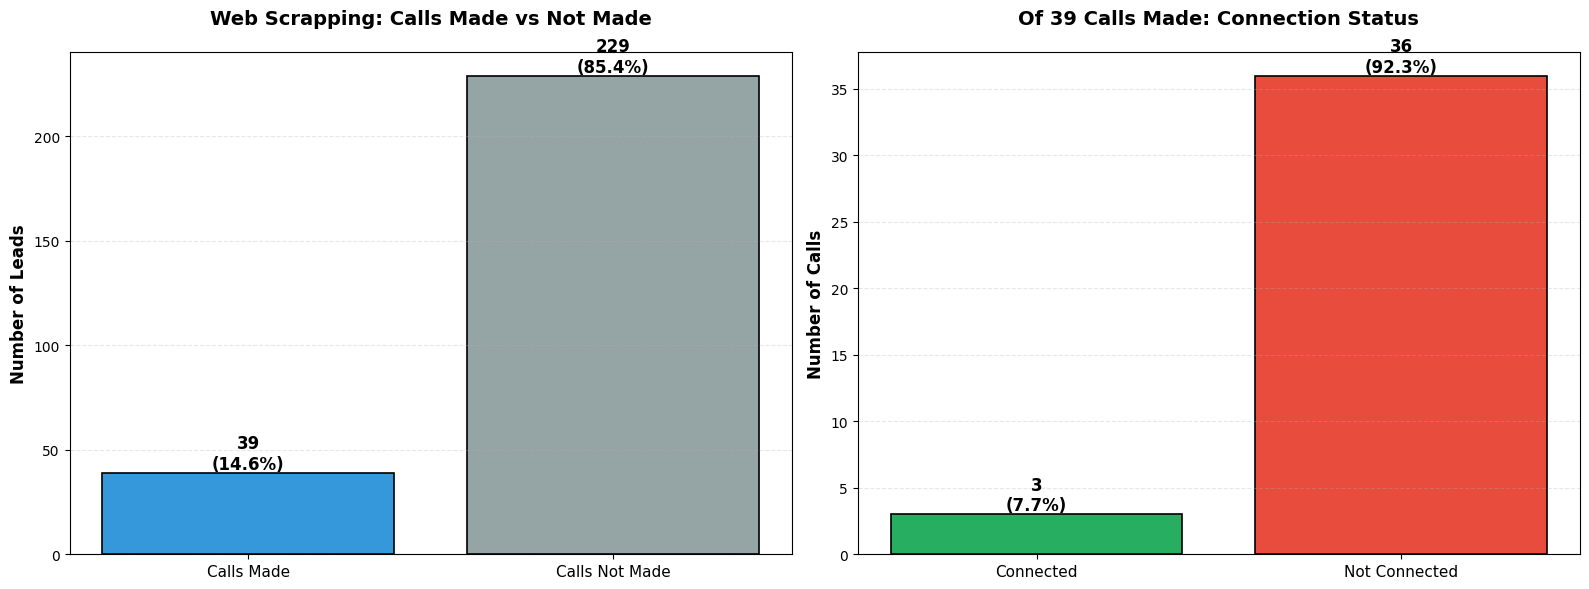


=== Detailed Breakdown ===
Total Web Scrapping Leads: 268

Call Activity:
  - Calls Made: 39 (14.55%)
  - Calls Not Made: 229 (85.45%)

Connection Rate (from calls made):
  - Connected: 3 (7.69%)
  - Not Connected: 36 (92.31%)


In [17]:
# Analyze Web Scrapping leads - Calls Made and Connection Rate
import matplotlib.pyplot as plt
import numpy as np

# Count total leads by Marketing Source from Master_DB_df
marketing_col = 'Marketing Source (Do not fill anything if the leads are from Hubspot, EPOS clients)'
source_counts = Master_DB_df[marketing_col].value_counts()

# Filter for Web Scrapping only
web_scrapping_row = source_counts[source_counts.index == 'Web Scrapping']

if not web_scrapping_row.empty:
    total_web_scrapping = web_scrapping_row.values[0]
    
    # Merge to get Web Scrapping leads with Call Outcome
    temp_merge = combined_researcher_df.merge(
        Master_DB_df[['ePOS Code', marketing_col]], 
        on='ePOS Code', 
        how='left'
    )
    
    # Filter for Web Scrapping leads only
    web_scrapping_leads = temp_merge[temp_merge[marketing_col] == 'Web Scrapping']
    
    # Find the correct column name for "Date of the 1st Call"
    possible_col_names = [
        'Date of the 1st Call',
        'Date of  the 1st  Call',
        'Date of the 1st  Call',
        'Date of  the 1st Call'
    ]
    
    first_call_col = None
    for col_name in possible_col_names:
        if col_name in web_scrapping_leads.columns:
            first_call_col = col_name
            break
    
    # If still not found, search for any column containing "1st" and "Call"
    if first_call_col is None:
        for col in web_scrapping_leads.columns:
            if '1st' in col and 'Call' in col and 'Date' in col:
                first_call_col = col
                break
    
    if first_call_col:
        # Count leads with calls made (those with '1st Call Date' filled)
        with_first_call = web_scrapping_leads[
            (web_scrapping_leads[first_call_col].notna()) & 
            (web_scrapping_leads[first_call_col].astype(str).str.strip() != '')
        ]
        calls_made_count = len(with_first_call)
        calls_made_pct = (calls_made_count / total_web_scrapping * 100) if total_web_scrapping > 0 else 0
        calls_not_made_count = total_web_scrapping - calls_made_count
        calls_not_made_pct = 100 - calls_made_pct
        
        # Of the calls made, count how many are connected
        connected_from_calls_made = with_first_call[with_first_call['Call Outcome'] == 'Connected']
        connected_from_calls_count = len(connected_from_calls_made)
        connected_from_calls_pct = (connected_from_calls_count / calls_made_count * 100) if calls_made_count > 0 else 0
        not_connected_from_calls_count = calls_made_count - connected_from_calls_count
        not_connected_from_calls_pct = 100 - connected_from_calls_pct
        
    else:
        print("⚠️ Warning: Could not find '1st Call Date' column")
        calls_made_count = 0
        calls_made_pct = 0
        calls_not_made_count = total_web_scrapping
        calls_not_made_pct = 100
        connected_from_calls_count = 0
        connected_from_calls_pct = 0
        not_connected_from_calls_count = 0
        not_connected_from_calls_pct = 0
    
    print("=== Web Scrapping Lead Analysis ===")
    print(f"Total Web Scrapping Leads: {total_web_scrapping}")
    print(f"\nCalls Status:")
    print(f"  Calls Made: {calls_made_count} ({calls_made_pct:.2f}%)")
    print(f"  Calls Not Made: {calls_not_made_count} ({calls_not_made_pct:.2f}%)")
    print(f"\nOf the {calls_made_count} calls made:")
    print(f"  Connected: {connected_from_calls_count} ({connected_from_calls_pct:.2f}%)")
    print(f"  Not Connected: {not_connected_from_calls_count} ({not_connected_from_calls_pct:.2f}%)")
    
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Chart 1: Calls Made vs Not Made
    categories1 = ['Calls Made', 'Calls Not Made']
    values1 = [calls_made_count, calls_not_made_count]
    colors1 = ['#3498DB', '#95A5A6']
    bars1 = ax1.bar(categories1, values1, 
                    color=colors1, edgecolor='black', linewidth=1.2)
    
    # Add value labels on bars
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        pct = (height / total_web_scrapping * 100)
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}\n({pct:.1f}%)',
                 ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax1.set_ylabel('Number of Leads', fontsize=12, fontweight='bold')
    ax1.set_title('Web Scrapping: Calls Made vs Not Made', fontsize=14, fontweight='bold', pad=20)
    ax1.tick_params(axis='x', labelsize=11)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Chart 2: Of Calls Made - Connected vs Not Connected
    categories2 = ['Connected', 'Not Connected']
    values2 = [connected_from_calls_count, not_connected_from_calls_count]
    colors2 = ['#27AE60', '#E74C3C']
    bars2 = ax2.bar(categories2, values2, 
                    color=colors2, edgecolor='black', linewidth=1.2)
    
    # Add value labels on bars
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        if calls_made_count > 0:
            pct = (height / calls_made_count * 100)
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                     f'{int(height)}\n({pct:.1f}%)',
                     ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax2.set_ylabel('Number of Calls', fontsize=12, fontweight='bold')
    ax2.set_title(f'Of {calls_made_count} Calls Made: Connection Status', fontsize=14, fontweight='bold', pad=20)
    ax2.tick_params(axis='x', labelsize=11)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    # Display detailed breakdown
    print(f"\n=== Detailed Breakdown ===")
    print(f"Total Web Scrapping Leads: {total_web_scrapping}")
    print(f"\nCall Activity:")
    print(f"  - Calls Made: {calls_made_count} ({calls_made_pct:.2f}%)")
    print(f"  - Calls Not Made: {calls_not_made_count} ({calls_not_made_pct:.2f}%)")
    print(f"\nConnection Rate (from calls made):")
    print(f"  - Connected: {connected_from_calls_count} ({connected_from_calls_pct:.2f}%)")
    print(f"  - Not Connected: {not_connected_from_calls_count} ({not_connected_from_calls_pct:.2f}%)")
else:
    print("⚠️ No 'Web Scrapping' leads found in Master_DB_df")

#  Leads by Industry 


=== Top 5 Sub Industries by Connected Calls ===
Total Connected Calls: 1299

Top 5 Breakdown:
Fashion & Apparel: 136 calls (10.5%)
Beauty & Wellness (Spas, Massage, Skincare): 117 calls (9.0%)
General Cleaning Services: 114 calls (8.8%)
Restaurants: 97 calls (7.5%)
Cafes & Coffee Shops: 96 calls (7.4%)


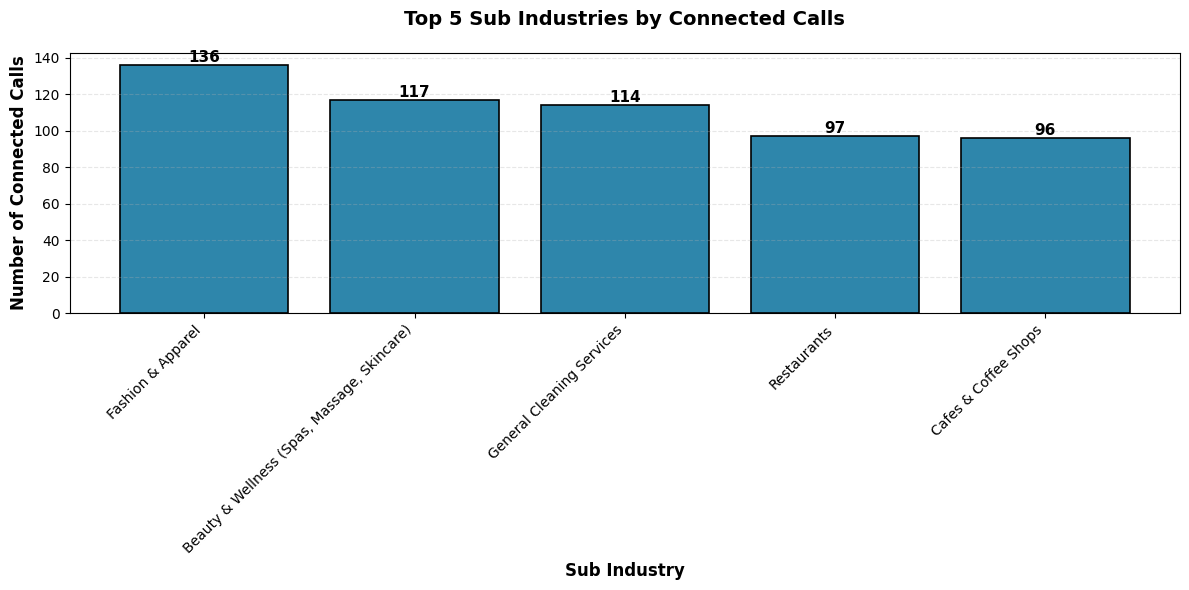

In [18]:
# Filter data where Call Outcome is 'Connected'
connected_calls = combined_researcher_df[combined_researcher_df['Call Outcome'] == 'Connected']

# Count connected calls by Sub Industry and get top 5
sub_industry_connected_counts = connected_calls['Sub Industry'].value_counts().sort_values(ascending=False).head(5)

# Create column chart
plt.figure(figsize=(12, 6))
bars = plt.bar(sub_industry_connected_counts.index, sub_industry_connected_counts.values, color='#2E86AB', edgecolor='black', linewidth=1.2)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xlabel('Sub Industry', fontsize=12, fontweight='bold')
plt.ylabel('Number of Connected Calls', fontsize=12, fontweight='bold')
plt.title('Top 5 Sub Industries by Connected Calls', fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()

# Display summary statistics
print("\n=== Top 5 Sub Industries by Connected Calls ===")
print(f"Total Connected Calls: {len(connected_calls)}")
print(f"\nTop 5 Breakdown:")
for sub_industry, count in sub_industry_connected_counts.items():
    percentage = (count / len(connected_calls)) * 100
    print(f"{sub_industry}: {count} calls ({percentage:.1f}%)")

plt.show()


=== Connected Calls by Industry Type (Master Database) ===
Total Connected Calls: 1299

Breakdown by Industry Type:
Retail: 502 calls (38.6%)
Services: 331 calls (25.5%)
F&B: 242 calls (18.6%)
Hospital: 89 calls (6.9%)
Wholesale Trade: 45 calls (3.5%)
: 40 calls (3.1%)
Manufacturing: 15 calls (1.2%)
Information & Digital Technology: 7 calls (0.5%)
Science, Innovation & Design: 7 calls (0.5%)
Built Environment & Infrastructure: 6 calls (0.5%)
Finance, Legal & Real Estate: 4 calls (0.3%)
Automobile: 4 calls (0.3%)
Educational: 2 calls (0.2%)
Primary Industries: 2 calls (0.2%)
Hospitals: 1 calls (0.1%)
Media: 1 calls (0.1%)
Transport & Logistics (Non-Road): 1 calls (0.1%)


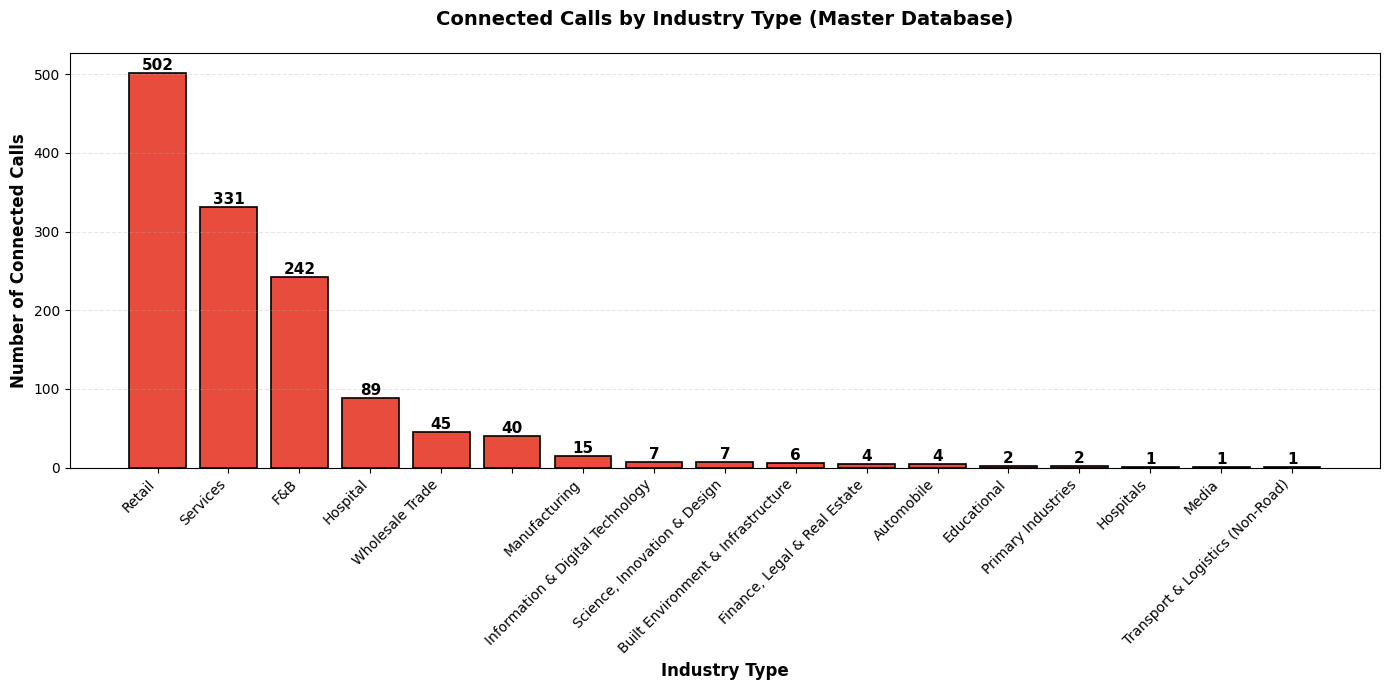

In [19]:
# Filter Master_DB_df where Call Outcome is 'Connected'
connected_master = Master_DB_df[Master_DB_df['Call Outcome'] == 'Connected']

# Count connected calls by Industry Type
industry_type_connected_counts = connected_master['Industry Type'].value_counts().sort_values(ascending=False)

# Create column chart
plt.figure(figsize=(14, 7))
bars = plt.bar(industry_type_connected_counts.index, industry_type_connected_counts.values, 
               color='#E74C3C', edgecolor='black', linewidth=1.2)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xlabel('Industry Type', fontsize=12, fontweight='bold')
plt.ylabel('Number of Connected Calls', fontsize=12, fontweight='bold')
plt.title('Connected Calls by Industry Type (Master Database)', fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()

# Display summary statistics
print("\n=== Connected Calls by Industry Type (Master Database) ===")
print(f"Total Connected Calls: {len(connected_master)}")
print(f"\nBreakdown by Industry Type:")
for industry_type, count in industry_type_connected_counts.items():
    percentage = (count / len(connected_master)) * 100
    print(f"{industry_type}: {count} calls ({percentage:.1f}%)")

plt.show()


=== Meetings Fixed by Industry Type ===
Total Meetings Fixed: 90
Total Rows in Master DB: 13968
Meeting Rate: 0.64%

Breakdown by Industry Type:
Retail: 31 meetings (34.4%)
Services: 28 meetings (31.1%)
F&B: 14 meetings (15.6%)
Hospital: 6 meetings (6.7%)
Information & Digital Technology: 3 meetings (3.3%)
: 2 meetings (2.2%)
Science, Innovation & Design: 2 meetings (2.2%)
Manufacturing: 1 meetings (1.1%)
Automobile: 1 meetings (1.1%)
Transport & Logistics (Non-Road): 1 meetings (1.1%)
Wholesale Trade: 1 meetings (1.1%)


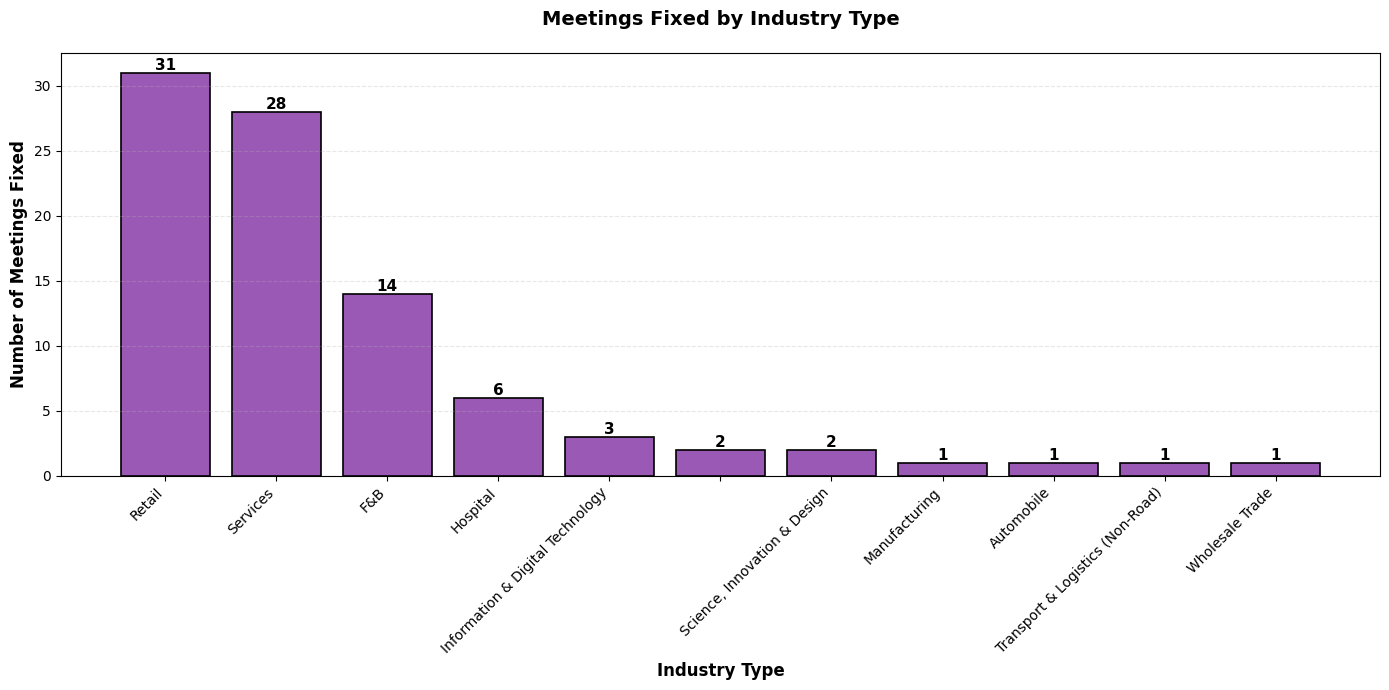

In [20]:
# Filter Master_DB_df where Meeting Fixed Date has any value (date or any text)
rows_with_meeting = Master_DB_df[
    (Master_DB_df['Meeting Fixed Date'].notna()) & 
    (Master_DB_df['Meeting Fixed Date'].astype(str).str.strip() != '')
]

# Count by Industry Type
meeting_fixed_by_industry = rows_with_meeting['Industry Type'].value_counts().sort_values(ascending=False)

# Create column chart
plt.figure(figsize=(14, 7))
bars = plt.bar(meeting_fixed_by_industry.index, meeting_fixed_by_industry.values, 
               color='#9B59B6', edgecolor='black', linewidth=1.2)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xlabel('Industry Type', fontsize=12, fontweight='bold')
plt.ylabel('Number of Meetings Fixed', fontsize=12, fontweight='bold')
plt.title('Meetings Fixed by Industry Type', fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()

# Display summary statistics
print("\n=== Meetings Fixed by Industry Type ===")
print(f"Total Meetings Fixed: {len(rows_with_meeting)}")
print(f"Total Rows in Master DB: {len(Master_DB_df)}")
print(f"Meeting Rate: {(len(rows_with_meeting) / len(Master_DB_df) * 100):.2f}%")
print(f"\nBreakdown by Industry Type:")
for industry_type, count in meeting_fixed_by_industry.items():
    percentage = (count / len(rows_with_meeting)) * 100
    print(f"{industry_type}: {count} meetings ({percentage:.1f}%)")

plt.show()